## ABOUT THIS NOTEBOOK
***

Landslides are widely recognized as a major natural hazard, resulting in significant socio-economic and human losses T.hese impacts are further exacerbated by increasingly frequent extreme weather events linked to global climate warming and rapid urban developmett ([Grima et al., 2020](https://doi.org/10.1016/j.scitotenv.2020.141128); [Fidan et al., 2024](https://doi.org/10.1007/s11069-024-06487-3)). One important tool for studying landslides is the use of catalogs and inventories, which provide detailed records of past events. These records are invaluable for risk assessment, the development of effective mitigation strategies, and scientific research to better understand the processes contributing to landslide occurrences.Using landslide inventories, it is possible to analyze the spati-otemporal distribution of past events and topographic conditions, which play a crucial role in the initiation and progression of landslides by influencing the physical and hydrogeological conditions of hillslopes.

This uses the FraneItalia catalog ([Calvello and Pecoraro, 2021](https://doi.org/10.5281/zenodo.7923683)) of landslide events from 2010 to 2020 to describe the spatial and temporal distribution of landslides in Italy during the 2010s and the topographic characteristics that influence landslide development. The single landslide events and areal landslide events, as described in the original publication, are unified into a single comprehensive catalog, treating all recorded landslides as individual events."

## DATA USED
***
1. FraneItalia - a catalog of landslide events from 2010 to 2020 serves as an updated version of the data used in [Calvello and Pecoraro (2018)](https://doi.org/10.1186/s40677-018-0105-5). The earlier work discusses the methodology employed to compile this database.
2. Shuttle Radar Topography Mission (SRTM) - a near global-scale digital elevation mode (DEM)l with 300-m spatial resolution downloaded from [NASA Shuttle  Radar Topography Mission (2013)](https://doi.org10.5069/G9445JDFF). Comprehensive discussion of its methodology was published by [Farr et al. (2007)](https://doi.org/10.1029/2005RG000183).
3.  Italy regional bounday - a geospatial vector data downloaded from [MAPOG GIS Data](https://gisdata.mapog.com/italy/Region%20level%202). Its corresponding [GeoJSON](https://github.com/openpolis/geojson-italy/blob/master/geojson/limits_IT_regions.geojson) data was also used for visualization purpose.

## DATA ANALYSIS
***

Load libraries

In [107]:
# Data analysis
import geopandas as gpd
import math
import numpy as np
import pandas as pd
import scipy.stats as stats

# Visualization
from matplotlib.colors import BoundaryNorm
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from tabulate import tabulate

# Geospatial data processing
from affine import Affine
import folium
from folium.raster_layers import ImageOverlay
from osgeo import gdal
from pysheds.grid import Grid
import rasterio
from rasterio.features import geometry_window
from rasterio.plot import show
from rasterio.transform import from_origin
from shapely.geometry import Point
import whitebox

# File handling
import os
import re
import xlrd

# Web Scraping
from bs4 import BeautifulSoup
import html5lib
import requests

# Miscellaneous
import json
import subprocess
import textwrap

Setup for static map display

In [117]:
from selenium import webdriver #WEbDriver module
from selenium.webdriver.edge.service import Service #WebDriver service for MS Edge
from IPython.display import display, Image #for displaying image in jupyter notebook
import time

#filepath of the MS Edge WebDriver executable
edge_driver = os.getcwd() + '\\msedgedriver.exe'
webdriver_path = Service(edge_driver)

### Import Data

In [9]:
# Set working directory
workdir = os.path.join(os.getcwd(), 'Documents', 'data_analytics', 'FraneItalia')
excel = os.path.join(workdir, 'franeitalia.xlsx')

# Single landslide events
sle = pd.read_excel(excel, sheet_name='single_landslides')
# Multiple landslide events
ale = pd.read_excel(excel, sheet_name='multi_landslide')

# Combine sheets
df = pd.concat([sle, ale], ignore_index=True)
df.head()

id        lat       long          region       wz  \
0  2010-01-02_SLE_C1_001  40.637159  14.607553        Campania   Camp-3   
1  2010-01-02_SLE_C3_001  37.292000  13.536300          Sicily   Sici-E   
2  2010-01-04_SLE_C3_001  43.783508  12.137910  Emilia-Romagna   Emil-A   
3  2010-01-04_SLE_C3_002  44.057600  10.910200         Tuscany  Tosc-R1   
4  2010-01-04_SLE_C3_003  44.003600  10.242500         Tuscany  Tosc-S1   

      municipality                       site          initial_day time  \
0           Atrani      Ristorante "Zaccaria"  2010-02-01 00:00:00  NaN   
1  Porto Empedocle                Via Lincoln  2010-02-01 00:00:00  NaN   
2      Casteldelci  Frazione di Poggio Ancisa  2010-04-01 00:00:00  NaN   
3          Pistoia       Frazione di Pracchia  2010-04-01 00:00:00  NaN   
4        Seravezza      Frazione di Minazzana  2010-04-01 00:00:00  NaN   

  final_day  ... roads railways water_supplies gas_pipelines  \
0       NaN  ...   yes      NaN            NaN           NaN   
1       NaN  ...   yes      NaN            NaN           NaN   
2  13/01/10  ...   yes      NaN            NaN           NaN   
3       NaN  ...   yes      NaN            NaN           NaN   
4       NaN  ...   yes      NaN            NaN           NaN   

  electricity_grids telephone_networks other cars_with_persons  \
0               NaN                NaN   NaN               NaN   
1               NaN                NaN   NaN               NaN   
2               NaN                NaN   NaN               NaN   
3               NaN                NaN   NaN               NaN   
4               NaN                NaN   NaN               NaN   

  cars_without_persons other_elements  
0                  NaN            NaN  
1                  NaN            NaN  
2                  NaN            NaN  
3                  NaN            NaN  
4                  NaN            NaN  

[5 rows x 34 columns]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7225 entries, 0 to 7224
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    7225 non-null   object 
 1   lat                   7225 non-null   float64
 2   long                  7225 non-null   float64
 3   region                7225 non-null   object 
 4   wz                    7225 non-null   object 
 5   municipality          7216 non-null   object 
 6   site                  6795 non-null   object 
 7   initial_day           7225 non-null   object 
 8   time                  2439 non-null   object 
 9   final_day             888 non-null    object 
 10  typology              2132 non-null   object 
 11  areal_dimensions      1076 non-null   object 
 12  volume_m3             585 non-null    object 
 13  trigger               7225 non-null   object 
 14  material              3999 non-null   object 
 15  activity_phase       

In [11]:
# Check total null values per column
df.isnull().sum()

id                         0
lat                        0
long                       0
region                     0
wz                         0
municipality               9
site                     430
initial_day                0
time                    4786
final_day               6337
typology                5093
areal_dimensions        6149
volume_m3               6640
trigger                    0
material                3226
activity_phase             0
victims                 7112
missing                 7221
wounded                 7015
evacuated               6371
residential             6589
public                  6950
factories               7107
paths                   6891
roads                   2078
railways                7036
water_supplies          6935
gas_pipelines           7127
electricity_grids       7041
telephone_networks      7170
other                   6936
cars_with_persons       6932
cars_without_persons    7024
other_elements          5993
dtype: int64

### Wrangling Data

#### Create new columns for 'Month' and 'Year'of landslide occurrence.

In [13]:
# Reformat 'initial_day' column to yyyy/mm/dd
df['initial_day'] = pd.to_datetime(df['initial_day'], errors='coerce') # set inconsistent values as NaT
df['initial_day'] = df['initial_day'].dt.strftime('%m/%d/%Y') # convert datetime to desired format
df['initial_day'] = pd.to_datetime(df['initial_day'], format='%m/%d/%Y') # set column as datetime64 dtype

# Create new columns
df['year'] = df['initial_day'].dt.year
df['month'] = df['initial_day'].dt.month
df[['initial_day', 'year', 'month']].tail()

initial_day  year  month
7220  2020-09-12  2020      9
7221  2020-12-20  2020     12
7222  2020-12-20  2020     12
7223  2020-12-26  2020     12
7224  2020-12-26  2020     12

#### Standardize all columns indicating the number of persons affected by landslide

Check 'victims' column

In [15]:
df['victims'].unique()

array(['1 person', nan, '11 persons', '2 persons', '1 person ',
       '4 persons', '3 persons'], dtype=object)

Check 'missing' column

In [17]:
df['missing'].unique()

array([nan, '1 person', '2 persons'], dtype=object)

Check 'wounded' column

In [19]:
df['wounded'].unique()

array([nan, '4 persons', '28 persons', '2 persons', '3 persons',
       '1 person', 'several persons', '21 persons', '25 persons',
       ' 1 person', '1 person ', '10 persons', '6 persons', '5 persons'],
      dtype=object)

Check 'evacuated' column

In [21]:
df['evacuated'].unique()

array([nan, '26 persons', '3 families', 'several families', '200 persons',
       '10 families', '32 families', '2 families', '14 families',
       '1 family', '6 families', '7 persons', '7 families', '13 persons',
       '110 persons', '60 persons (23 families)',
       '7 persons (3 families) ', '60 persons', 'several persons',
       '10 persons', '3 persons', '22 families',
       'several families + 1 school', '1 residential building',
       '2 persons', '4 families', '8 persons', '4 persons', '5 persons',
       '18 persons', '20 families (whole village)', '20 persons',
       '1 person', '12 (residential buildings + factories)', '33 persons',
       '15 persons', '30 persons', 'owners of farmhouse "Col di Stogno"',
       '12 persons', '5 families', '100 persons', '30 families',
       '8 families', '19 families', '40 persons', '5 persons (1 family)',
       '6 persons', '6 persons (1 family) ', '36 persons', '150 persons',
       'whole village', '11 persons (5 families)', '9 

Most of the affected individuals are quantified as number of persons or grouped as families. Also, there are entries that were grouped based on the structure they were in (e.g. residential building, school, etc.). The entries from the four columns must be standardized in order to estimate the actual number of individuals affected by landslides. 

In [23]:
df.loc[df['evacuated'] == '20 families (50-60 persons)', 'evacuated'] = '55 persons (20 families)'
df.loc[df['evacuated'] == 'hundreds of persons', 'evacuated'] = '100 persons'
df.loc[df['evacuated'] == 'tens of persons', 'evacuated'] = '10 persons'
df.loc[df['evacuated'] == '130-150 persons (54 families)', 'evacuated'] = '140 persons (54 families)'

A function has been developed to convert the number of families into individual persons. Note that between 2010 and 2020, the average number of persons per household in Italy was approximately 2.33 ([GlobalData, 2024](https://www.globaldata.com/data-insights/macroeconomic/average-household-size-in-italy-2096127/#:~:text=Average%20Size%20of%20Households%20in%20Italy%20%282010%20-,average%20household%20size%20in%20Italy%20decreased%20by%203.4%25)). The affected people that were grouped based on the structure they were in are not considered. Therefore, the corresponding tally represents the minimum number of persons affected by landslides.


In [25]:
'''
Function 'family_to_persons' converts all entries from df['evacuated'] to number of persons.

Criteria:
1. If entry is X persons, function retains X number of person.
2. If entry is X families, function will convert to X persons by multiplying X with 2.33.
3. If evacuees are X persons and X families, the function will count the total persons by converting the families to persons before adding them together.
4. Non numerical entries or entries without definite number of persons (e.g., 1 school, 2 villages, 3 residential buildings, etc.) will be set to NaN.
'''

def family_to_persons(entry):
    # Define a numerical pattern in column
    pattern = r'\d+'

    # If entry is NaN, return NaN
    if pd.isna(entry):
        return np.nan

    # Convert all entries to lowercase
    entry = entry.lower()
    
    # Initialize total_pax
    total_pax = 0
    
    # CRITERIA 3
    # Check if entry has '+'
    if '+' in entry:
        # Split entry at '+'
        parts = entry.split('+')
        for part in parts:
            # Remove extra whitespaces
            part = part.strip()
            if 'person' in part or 'persons' in part:
                # Extract numerical values
                numbers = re.findall(pattern, part)
                if numbers:
                    total_pax += sum([int(num) for num in numbers])
            elif 'family' in part or 'families' in part:
                numbers = re.findall(pattern, part)
                if numbers:
                    # Compute total pax from families
                    total_pax += int(numbers[0]) * 2.33

    # If entry is w/o '+'
    else:
        # CRITERIA #1
        if 'person' in entry or 'persons' in entry:
            numbers = re.findall(pattern, entry)
            if numbers:
                total_pax = int(numbers[0])

        # CRITERIA #2
        elif 'family' in entry or 'families' in entry:
            numbers = re.findall(pattern, entry)
            if numbers:
                # Compute total pax from families
                total_pax = int(numbers[0]) * 2.33

    return total_pax

In [26]:
# Apply function to dataframe
columns = ['victims', 'missing', 'wounded', 'evacuated']

for column in columns:
    df[column] = df[column].apply(family_to_persons)
    
# Create new column 'total_pax_affected' containing the sum of victims, missing, wounded, and evacuated
df['total_pax_affected'] = df[['victims', 'missing', 'wounded', 'evacuated']].sum(axis=1)

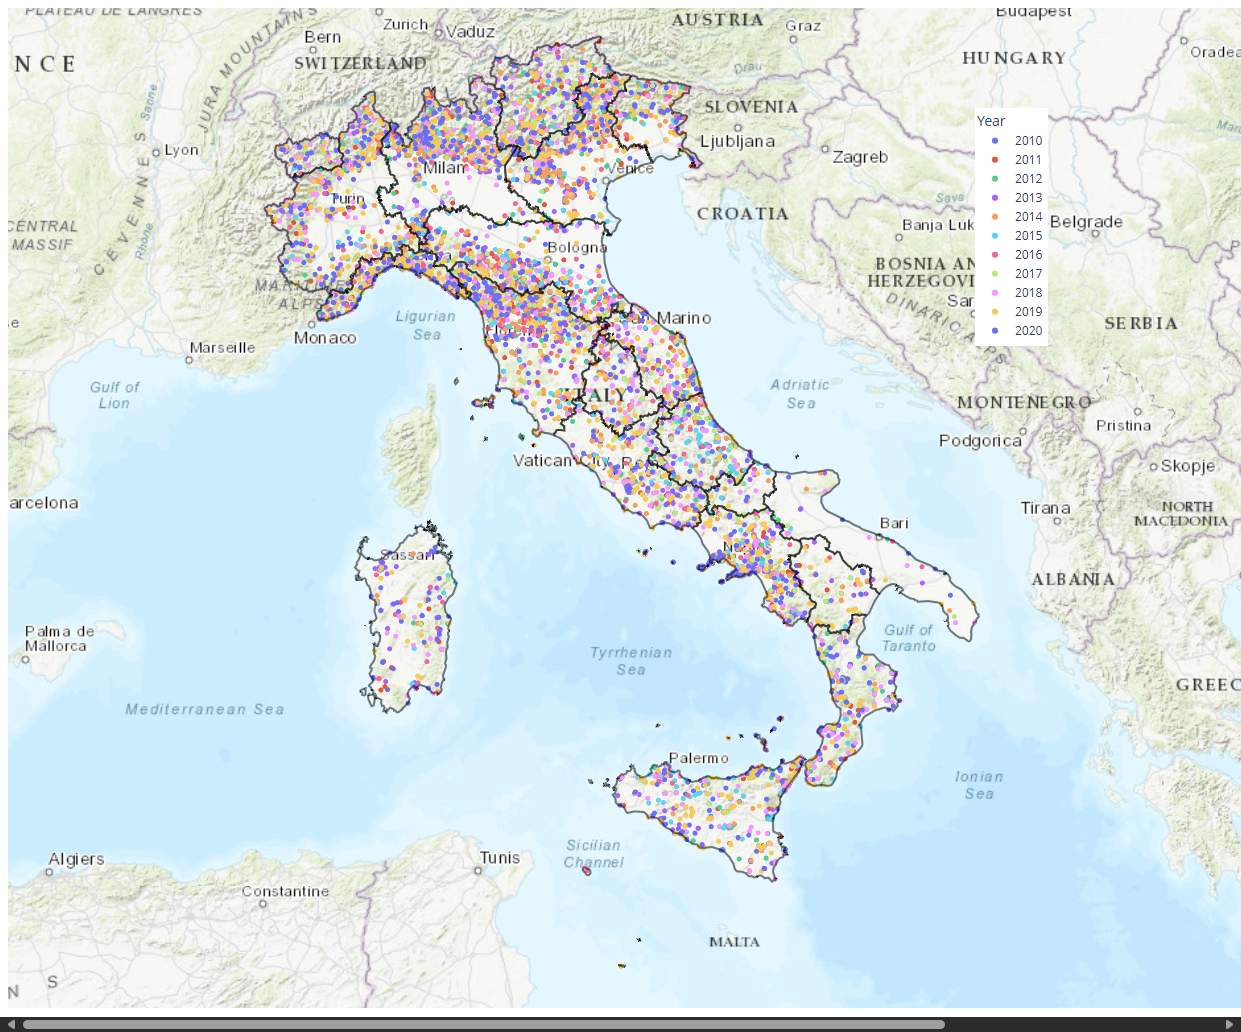

In [131]:
# Define GeoJSON
geojson_file = os.path.join(workdir, 'Italy_regions.geojson')

# Load GeoJSON
with open(geojson_file) as f:
    italy_geojson = json.load(f)

df['year'] = df['year'].astype(str)
fig = px.scatter_mapbox(df, lat='lat', lon='long', zoom=5.4, color='year',
                       center={"lat": 41.475620, "lon": 15.676137},
                       height=300, size_max=5)

fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "Esri",
            "source": ["https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}"]
        },
        {
            "sourcetype": "geojson",
            "source": italy_geojson,
            "type": "line",
            "color": "rgba(0, 0, 0, 0.5)" 
        }
    ]
)

# Adjust the layout, including the size of the figure and legend display
fig.update_layout(
    width=1600, height=1000,
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    showlegend=True,  # Ensure the legend is shown
    legend=dict(
        title="Year",  # Legend title
        orientation="v",  # Vertical orientation for the legend
        yanchor="top",  # Align legend to the top of the figure
        y=0.9,
        xanchor="right",
        x=0.65
    )
)

# display interactive plotly map
#fig.show()

# display mapbox as static png file:
map_html_file = "ita_ls_inv.html" #Create instance of html
fig.write_html(map_html_file) #Save the map as an HTML file
driver = webdriver.Edge(service=webdriver_path) #Create a WebDriver instance for Microsoft Edge
driver.get(os.getcwd() + '\\' + map_html_file)  #Open the HTML file in the WebDriver
time.sleep(10) #Wait for the map to load
screenshot_path = 'ita_ls_inv.png' #create instance of screenshot map
driver.save_screenshot(screenshot_path) #Capture a screenshot of the page
driver.quit() #Close the WebDriver
display(Image(filename=screenshot_path)) #display screenshot

##### Insights
***
- Most landslide events occur in mountainous regions in the Italy, mainly in the Alps and the Appenines.

#### Types of Recorded Landslides

Landslides may vary depending on the type of movement. [Varnes (1978)](https://onlinepubs.trb.org/Onlinepubs/sr/sr176/176-002.pdf), followed by [Cruden and Varnes (1996)](https://onlinepubs.trb.org/Onlinepubs/sr/sr247/sr247-003.pdf) classified landslides into four main types—fall, flow, slide, and topple—while also considering the type of material moved, such as rock falls and debris flows. Most of these landslide types share common triggers, including rainfall and earthquakes, which can lead to simultaneous occurrences or a cascade effect where one type triggers another. The likelihood and nature of these events are influenced by geological and environmental conditions, such as slope stability, soil saturation, and the presence of vegetation. In this context, the typology of landslide events in the database is checked.

In [30]:
df['typology'].value_counts()

typology
fall             1266
flow              427
slide             361
more than one      76
                    1
 flow               1
Name: count, dtype: int64

#### Spatial distribution of landslides in Italy
Spatial distribution of landslides on each region can be measured using landslide density. In this exercise, the _landslide index_ (LI) introduced by [Calvello and Pecoraro (2018)](https://doi.org/10.1186/s40677-018-0105-5) is used to represent the density of landslide for each region. Landslide index is defined by the ratio between the number of landslides per region over total number of landslides in Italy and surface area per region over total surface area of Italy. LI>1 suggests that the density of landslides in a given region is higher that the national average ([Havenith et al., 2015](https://doi.org/10.1016/j.geomorph.2015.03.019); [Calvello and Pecoraro, 2018](https://doi.org/10.1186/s40677-018-0105-5)).

The first step on computing LI is to identify the surface area of Italy and each of its regions.

In [32]:
# Get information on surface area per region

# Scrape data from wikipedia page: Regions of Italy
url = 'https://en.wikipedia.org/wiki/Regions_of_Italy'

response = requests.get(url).text

soup = BeautifulSoup(response, 'html5lib')

# Get table of regions
table = soup.find('table', class_='wikitable sortable')

# Define list
region_list = []
size_list = []

# Loop through table
for row in soup.find_all('tr'):
    # Find all table columns in each row
    columns = row.find_all('td')
    # Proceed if there are columns
    if len(columns) > 0:
        try:
            # Get region name from 'title' attribute
            region_name = columns[1].find('a')['title']
            # Extract region size
            region_size = columns[5].text.strip().split()[0]
            # Add extracted data to lists
            region_list.append(region_name)
            size_list.append(region_size)
        except IndexError:
            continue
        except TypeError:
            break

# Create new table
italy_regions = {'Region': region_list, 'Area (sqkm)': size_list}
italy_regions = pd.DataFrame(italy_regions)

# Make spelling of 'Region' column consistent to that of the catalog
#italy_regions.loc[italy_regions['Region'] == 'Apulia', 'Region'] = 'Puglia'
italy_regions.loc[italy_regions['Region'] == 'Aosta Valley', 'Region'] = 'Aosta valley'
italy_regions.loc[italy_regions['Region'] == 'Trentino-Alto Adige/Südtirol', 'Region'] = 'Trentino-Alto Adige'

# Change dtype of column 'Area (sqkm)'
italy_regions['Area (sqkm)'] = italy_regions['Area (sqkm)'].str.replace(',', '').astype(int)

###################################################################################################################################################
# Tabulate LI of each region

# Define total landslides in Italy
landslide_total = df.shape[0]

# List
region_list = list(italy_regions['Region'].unique())
regional_landslides = [] #  total landslides per region
landslideindex = []

# Count total landslides per region
for region in region_list:
    reg_total = df[df['region'] == region].shape[0]
    regional_landslides.append(reg_total)

col3 = {'Total Landslides': regional_landslides}
italy_regions['Total Landslides'] = col3['Total Landslides']

# Compute LI
for region in region_list:
    # Total number of landslides per region / Total landslides in Italy
    numerator = (italy_regions.loc[italy_regions['Region'] == region, 'Total Landslides'].values[0])/(italy_regions['Total Landslides'].sum())
    # Surface area per region / Surface area of Italy
    denominator = (italy_regions.loc[italy_regions['Region'] == region, 'Area (sqkm)'].values[0])/(italy_regions['Area (sqkm)'].sum())
    # Landslide index
    ls_idx = numerator/denominator
    landslideindex.append(ls_idx)
    
col4 = {'Landslide Index': landslideindex}
italy_regions['Landslide Index'] = col4['Landslide Index']
italy_regions

Region  Area (sqkm)  Total Landslides  Landslide Index
0                 Abruzzo        10832               267         1.030565
1            Aosta valley         3261                85         1.089785
2                  Apulia        19541                32         0.068466
3              Basilicata        10073                70         0.290544
4                Calabria        15222               292         0.802017
5                Campania        13671               608         1.859413
6          Emilia-Romagna        22453               518         0.964557
7   Friuli-Venezia Giulia         7924               202         1.065809
8                   Lazio        17232               391         0.948667
9                 Liguria         5416               482         3.720840
10               Lombardy        23864               849         1.487432
11                 Marche         9401               276         1.227461
12                 Molise         4461                41         0.384259
13               Piedmont        25387               441         0.726273
14               Sardinia        24100               144         0.249815
15                 Sicily        25832               573         0.927405
16    Trentino-Alto Adige        13606               355         1.090864
17                Tuscany        22987               852         1.549637
18                 Umbria         8464               154         0.760707
19                 Veneto        18345               593         1.351480

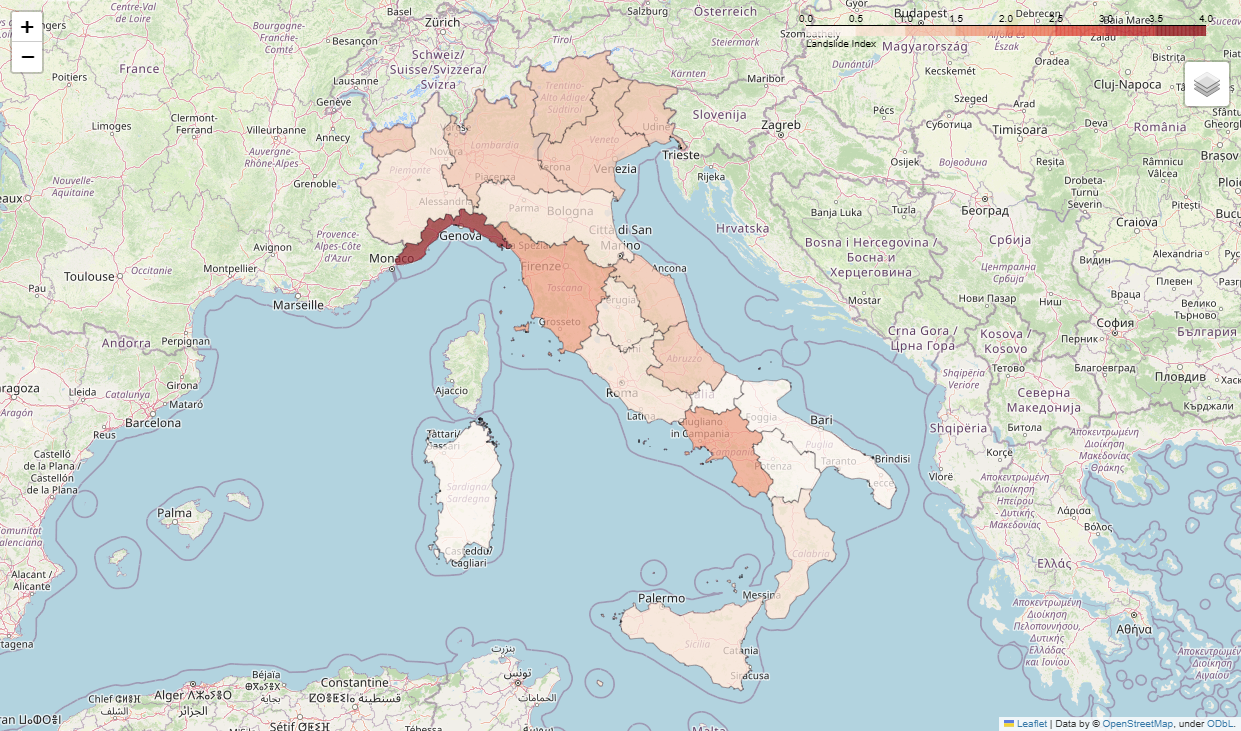

In [133]:
# Load GeoJSON
italy_geojson = os.path.join(workdir, 'Italy_regions.geojson')
geojson_italy = gpd.read_file(italy_geojson)

# Italy map
italy_map = folium.Map(location = [41.2925, 12.5736], zoom_start = 5.7)

# Basemap
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}",
    attr='Esri',
    name='Esri WorldTopoMap'
).add_to(italy_map)

# Choropleth 
folium.Choropleth(
    geo_data=italy_geojson,
    data=italy_regions,
    columns=['Region', 'Landslide Index'],
    key_on='feature.properties.reg_name',
    fill_color='Reds',
    threshold_scale=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4],
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Landslide Index'
).add_to(italy_map)

# Code below was adapted from https://vverde.github.io/blob/interactivechoropleth.html

# Merge the geojson with the dataframe for tooltips
geojson_italy = geojson_italy.merge(italy_regions, left_on='reg_name', right_on='Region')

# Default style of GeoJSON when not highlighted
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}

# Default style of GeoJSON when highlighted
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

hover = folium.features.GeoJson(
    geojson_italy,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['reg_name', 'Total Landslides', 'Landslide Index'],
        aliases=['Region: ', 'Total Reported Landslides: ', 'Landslide Index: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)

# Display map
italy_map.add_child(hover)
#italy_map.keep_in_front(hover)
folium.LayerControl().add_to(italy_map)
# display interactive folium map
#italy_map

# display italy_map as static png file:
map_html_file = "ita_lsi.html" #Create instance of html (rename html as needed)
italy_map.save(map_html_file) #Save the map as an HTML file
driver = webdriver.Edge(service=webdriver_path) #Create a WebDriver instance for Microsoft Edge
driver.get(os.getcwd() + '\\' + map_html_file)  #Open the HTML file in the WebDriver
time.sleep(10) #Wait for the map to load
screenshot_path = 'ita_lsi.png' #create instance of screenshot map (rename png as needed)
driver.save_screenshot(screenshot_path) #Capture a screenshot of the page
driver.quit() #Close the WebDriver
display(Image(filename=screenshot_path)) #display screenshot

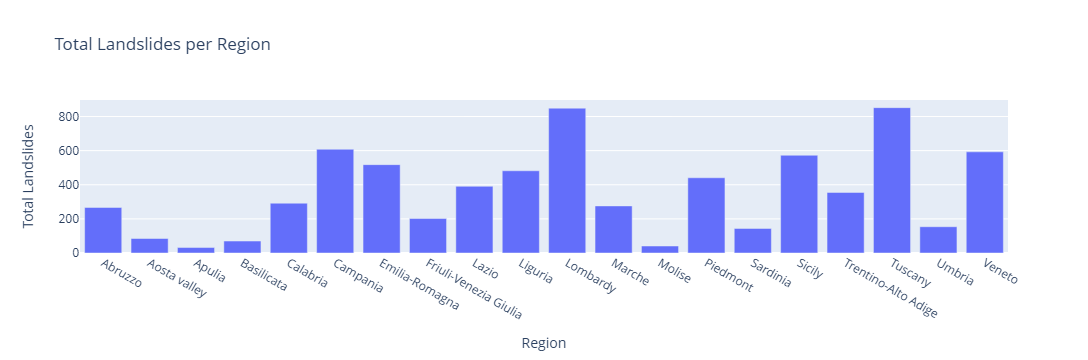

In [34]:
### Show total landslides per region

lstot_per_reg = px.bar(italy_regions, x='Region', y='Total Landslides', title='Total Landslides per Region')
lstot_per_reg.show()

##### Insights
***
- Despite ranking 6th in reported landslides, Liguria has the highest concentration of landslides in Italy, characterized by the rugged terrain of the Alps and Apennines.
- Among Italy's Alpine regions, only Piedmont has an LI below 1 because its extensive area is part of the Po Valley.
- Tuscany and Campania have the highest landslide densities in the Apennines. In Tuscany, landslides are concentrated in the north, while in Campania, they are prevalent around Campi Flegrei and the Lattari Mountains.

#### Temporal distribution of landslides in Italy
Analyzing landslides over time allows the identification of pattern, trends, and potential landslide triggers. 

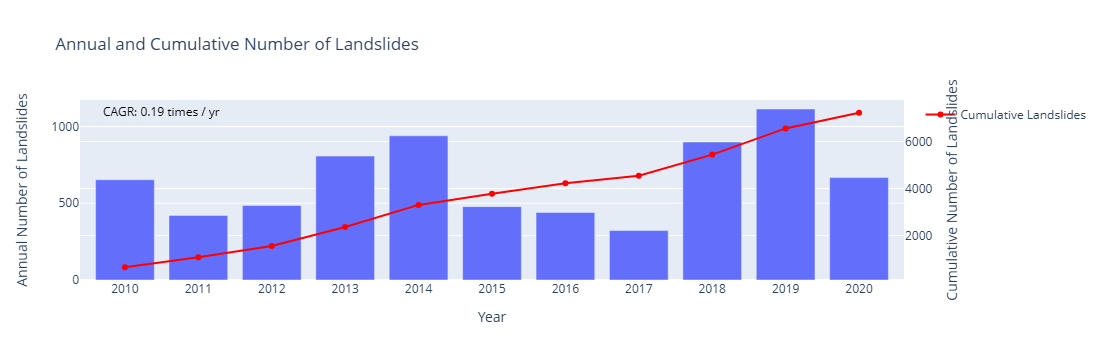

In [37]:
# Create dataframe of number of landslides per year
ls_year_df = df.groupby('year').size().reset_index(name='count')
ls_year_df['year'].astype(int)

# Add column of cumulative number of landslides
ls_year_df['cumulative_sum'] = ls_year_df['count'].cumsum()


# Compute growth rate
initial_year = ls_year_df.loc[ls_year_df['year'] == '2010', 'count'].values[0]
final_year = ls_year_df.loc[ls_year_df['year'] == '2020', 'count'].values[0]

cagr = ((final_year / initial_year) ** (1 / 11) - 1) * 100

# Annual total landslides
yearly_landslides = px.bar(ls_year_df, x='year', y='count', title='Annual Total Landslides',
                          labels={'count': 'Number of Landslides', 'year': 'Year'})

# Cumulative number of landslides
yearly_landslides.add_scatter(x=ls_year_df['year'], y=ls_year_df['cumulative_sum'], 
                              mode='lines+markers', name='Cumulative Landslides', 
                              line=dict(color='red'), yaxis='y2')

# Add secondary y-axis
yearly_landslides.update_layout(
    yaxis=dict(title='Annual Number of Landslides',),
    yaxis2=dict(title='Cumulative Number of Landslides', overlaying='y',
        side='right'),
    xaxis=dict(title='Year'),
    title='Annual and Cumulative Number of Landslides')

# Add growth rate 
yearly_landslides.add_annotation(
    x=0.5, y=1100,  # Adjust x and y coordinates for the annotation
    text=f'CAGR: {cagr:.2f} times / yr',
    showarrow=False,
    font=dict(size=12, color='black'),
)

yearly_landslides.show()

The number of landslide events varies annually due to several meteorological factors, such as climate and precipitation. Therefore, it is important to examine the seasonal variability of landslides. To explore this, the total monthly precipitation, in millimeters, from 1991-2020 ([The World Bank Group, 2021](https://climateknowledgeportal.worldbank.org/country/italy/climate-data-historical)) was analyzed to check for correlation with landslide occurrences.

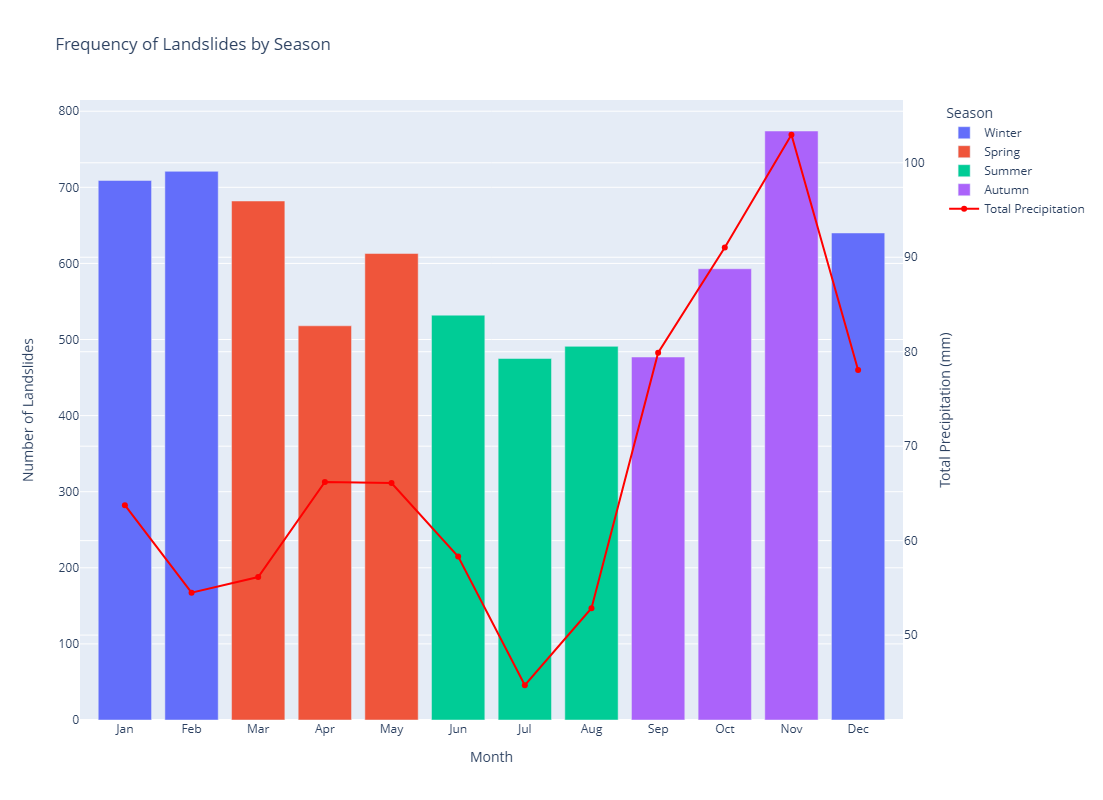

In [39]:
# List of monthly landslide totals 
monthly_landslides = []

# Count total landslides per region
for month in range(1,13):
    total_monthly_ls = df[df['month'] == month].shape[0]
    monthly_landslides.append(total_monthly_ls)

# Assign season to each month
seasons_col = []

for i in range(1,13):
    if i in [12,1,2,]:
        seasons_col.append('Winter')
    elif i in [3,4,5]:
        seasons_col.append('Spring')
    elif i in [6,7,8]:
        seasons_col.append('Summer')
    else:
        seasons_col.append('Autumn')


total_monthly_ls = {'Month': list(range(1, 13)), 'Season': seasons_col, 'Monthly Landslides': monthly_landslides}
total_monthly_ls_df = pd.DataFrame(total_monthly_ls)

# Add column of total monthly precipitation
total_monthly_ls_df['Precipitation'] = [63.75, 54.49, 56.15, 66.21, 66.09, 58.31,
                                       44.69, 52.84, 79.89, 91.04, 102.97, 78.07]

# Convert 'Month' column to a categorical type with the correct order
total_monthly_ls_df['Month'] = pd.Categorical(total_monthly_ls_df['Month'], categories=list(range(1, 13)), ordered=True)

# Plot Total landslides by month
monthly_landslides = px.bar(total_monthly_ls_df, x='Month', y='Monthly Landslides', title='Frequency of Landslides by Season',
                          labels={'count': 'Number of Landslides', 'year': 'Month'},
                           color='Season')

# Show all month labels
monthly_landslides.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(1, 13)),
        ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    )
)

# Add precipitation trendline
monthly_landslides.add_scatter(x=total_monthly_ls_df['Month'], y=total_monthly_ls_df['Precipitation'], 
                              mode='lines+markers', name='Total Precipitation', 
                              line=dict(color='red'), yaxis='y2')

# Add secondary y-axis
monthly_landslides.update_layout(
    yaxis=dict(title='Number of Landslides',),
    yaxis2=dict(title='Total Precipitation (mm)', overlaying='y',
        side='right'),
    xaxis=dict(title='Month'),
    title='Frequency of Landslides by Season',
    legend=dict(
        x=1.05,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

monthly_landslides.update_layout(width=1000, height=800)
monthly_landslides.show()

##### Insights
***
- From 2010 to 2020, the incidence of landslides in Italy has exhibited a notable overall increase, with annual growth rate of 0.19 times.
- Slight contractions are observed during the periods 2011-2012 and 2015-2017, primarily attributed to lower occurrences during those years or possibly an increase in unreported cases.
- In terms of seasonal variation, landslides are more frequent during colder seasons when precipitation is higher than the rest of the year. Landslide occurrences begin to increase in October, peak in November, and generally taper off until the end of spring of next year, with a notable exception in April.

### Effects of topography on landslide occurrence

Topographic conditions, shaped by geological and geomorphic processes, are key factors in inducing slope instability. With the public availability of DEMs, researchers can now derive proxy variables that are essential for assessing landslide susceptibility. DEMs provide detailed topographic data, enabling the extraction of landslide conditioning factors ([Mahalingam et al., 2016](https://doi.org/10.1080/19475705.2016.1172520)) such as slope gradient, aspect, curvature, and elevation, which significantly influence the likelihood of landslides. 

It is important to note that since SRTM images are used in this exercise, certain details of the topography may be obscured due to their oversmoothened features. This smoothing can result in the loss of important topographic variations that could affect analysis ([Lin et al., 2022](https://doi.org/10.3390/rs14092181)).

Before extracting data from the DEM raster, it is essential to clean the dataset by removing all landslide events that fall outside the DEM's coverage area.

In [42]:
# Open dtm raster
dem = workdir + '\\italy_dtm\\dem.tif'

# Open slope raster
dtm = gdal.Open(dem)
# Read raster into numpy array
dtm_array = dtm.GetRasterBand(1).ReadAsArray()

# Mask values < -32767 (i.e., No data pixels)
dtm_mask = np.ma.masked_less(dtm_array, -32767)

# List of elevation per landslide event
elevation = []

with rasterio.open(dem) as src:
    affine = src.transform
    
    for index, row in df.iterrows():
        lat = row['lat']
        lon = row['long']  # Use 'lon' to avoid conflict with 'row' as the DataFrame row
        
        # Get column and row from latitude and longitude
        col, r = ~affine * (lon, lat)
        r = int(r)
        col = int(col)
        
        # Check if lat/long are inside the raster array boundary
        if 0 <= r < dtm_mask.shape[0] and 0 <= col < dtm_mask.shape[1]:
            elevation_value = dtm_mask[r, col]
        else:
            elevation_value = None
            
        # Add elevation_value to elevation list
        elevation.append(elevation_value)

# Add elevation list to df as a new column
df['elevation'] = elevation

# Drop rows where df['elevation'] == -32767
df = df[df['elevation'] != -32767].reset_index(drop=True)
df.shape

(7196, 38)

A total of 29 landslide events were located outside the DEM coverage area and were subsequently removed from the dataset.

#### Slope
Slope controls stress and strain in the soil, geomorphic process, and hydrology ([Okoli et al., 2023](https://doi.org/10.3390/geosciences13020034)). Landslides are highly likely to occur on slopes with angles between 30° and 35°, but they can also occur on gentler slopes, including those with angles less than 10°, depending on the type of slope failure ([Soeters and Van Westen, 1996](https://onlinepubs.trb.org/Onlinepubs/sr/sr247/sr247.pdf); [Picarelli et al., 2005](https://www.taylorfrancis.com/chapters/edit/10.1201/9781439833711-5/hazard-characterization-quantification-picarelli-oboni-evans-mostyn-fell)). In this work, slope angles on each landslide events are reclassified into six classes following the example set by [Chen et al. (2020)](https://doi.org/10.1007/s11069-020-03899-9).

In [45]:
def compressor(inras, outras):
    """
    Using GDAL, this function reduces the file size of input raster geotiff by compression.

    Parameters:
    inras (str): The file path of the input raster (uncompressed).
    outras (str): The file path where the compressed raster will be saved.
    """
    
    # Compression options
    compression_options = [
    'COMPRESS=DEFLATE',  # Use DEFLATE compression (similar to ZIP)
    'PREDICTOR=2',       # Use horizontal differencing as a predictor
    'ZLEVEL=9',          # Maximum compression level (1-9, 9 is the highest)
    'TILED=YES'          # Create a tiled GeoTIFF
    ]

    # Translate (convert) the raster
    gdal.Translate(
    outras,
    inras,
    creationOptions=compression_options
    )

    # Optional: Delete uncompressed file
    os.remove(inras)

C:\Users\romercarlo\AppData\Local\Temp\ipykernel_28332\2919461499.py:91: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\romercarlo\AppData\Local\Temp\ipykernel_28332\2919461499.py:99: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



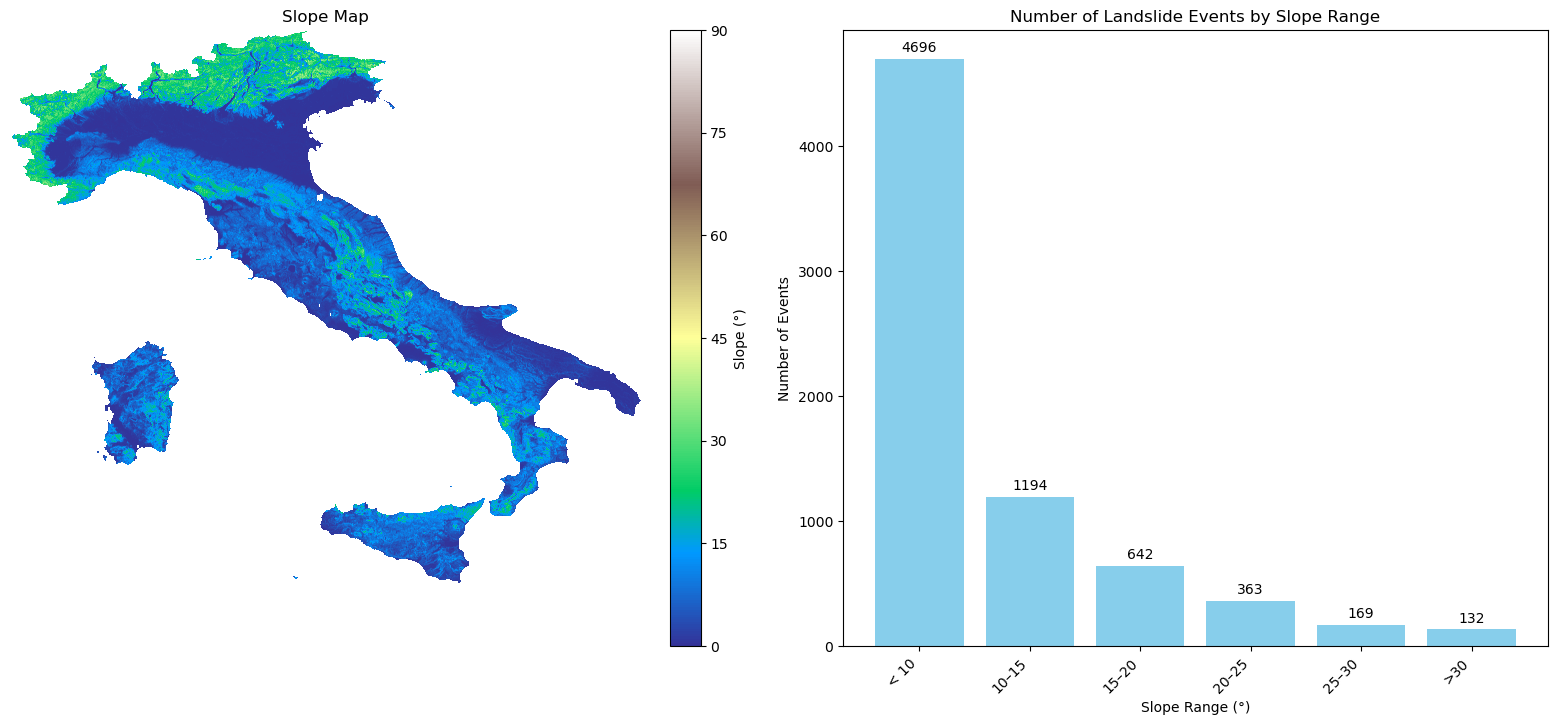

In [46]:
## Generate slope raster from SRTM

#Define files and output
#workdir = os.getcwd() + '\\Documents\\data_analytics\\FraneItalia\\italy_dtm\\'
dem = workdir + '\\italy_dtm\\dem.tif'
slope_uncompressed = workdir + '\\italy_dtm\\slope_unc.tif'
slope = workdir + '\\italy_dtm\\slope.tif'

# Command to generate slope raster
cmd = f"gdaldem slope {dem} {slope_uncompressed} -compute_edges -s 111120"
# Execute command
subprocess.call(cmd, shell=True)

# Reduce file size of slope raster
compressor(slope_uncompressed, slope)

# Open slope raster
slope = gdal.Open(slope)
# Read raster into numpy array
slope_array = slope.GetRasterBand(1).ReadAsArray()

# Mask values < 0
slope_mask = np.ma.masked_less(slope_array, 0)

#################################################################################################################
## Count number of landslide events per slope range.

# Define list to store slope values
slope_values = []

# Redefine slope raster
slope = os.path.join(workdir, 'italy_dtm', 'slope.tif')

with rasterio.open(slope) as f:
    affine = f.transform
    array = f.read(1) # Read band 1

    # Loop through df to get lat/long values 
    for index, row in df.iterrows():
        lat = row['lat']
        long = row['long']

        # Convert lat/long to row and column indices
        col, row = ~affine * (long, lat)
        row = int(row)
        col = int(col)

        # Check if lat/long are inside the raster array boundary
        if 0 <= row < array.shape[0] and 0 <= col < array.shape[1]:
            slope_value = array[row, col]
        else:
            slope_value = None

        # Add slope_value to slope_values
        slope_values.append(slope_value)

# Add to slope column to df
df['slope'] = slope_values

# Define bins and x-labels
slope_bins = [0, 10, 15, 20, 25, 30, float('inf')]
slope_labels = ['< 10', '10–15', '15–20', '20–25', '25–30', '>30']

# Bin the slope values and count occurrences in each bin
df['slope_range'] = pd.cut(df['slope'], bins=slope_bins, labels=slope_labels, right=False)
slope_count = df['slope_range'].value_counts().sort_index().reset_index()
slope_count.columns = ['slope_range', 'count']

#################################################################################################################
## Plot

# Create figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# 1. Slope map
cmap = plt.cm.terrain
cmap.set_bad(color='white')
im = axs[0].imshow(slope_mask, cmap=cmap, vmin=0, vmax=90)
cbar = fig.colorbar(im, ax=axs[0], fraction=0.046, pad=0.04)
cbar.set_label('Slope (°)')
cbar.set_ticks([0, 15, 30, 45, 60, 75, 90])
cbar.set_ticklabels(['0', '15', '30', '45', '60', '75', '90'])
axs[0].set_title('Slope Map')
axs[0].axis('off')

# 2. Bar chart
bars = axs[1].bar(slope_count['slope_range'], slope_count['count'], color='skyblue')
axs[1].set_xlabel('Slope Range (°)')
axs[1].set_ylabel('Number of Events')
axs[1].set_title('Number of Landslide Events by Slope Range')
axs[1].set_xticklabels(slope_count['slope_range'], rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    axs[1].annotate(f'{yval}', xy=(bar.get_x() + bar.get_width() / 2, yval),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Show plot
fig.show()

##### Insights
***
- From 2010 to 2020, about 86% of landslide events occurred on gently sloping terrain (≤20°), indicating that slope failures are particularly prevalent in near flat terrain where near communities are located.
- There is a progressive decrease in instability events on steeper slopes, particularly those greater than 30°, likely due to the prevalence of exposed bedrock, which is a geologically stronger material (e.g., [Donnarumma et al., 2013](https://doi.org/10.1007/978-3-642-31325-7_56)).
- The significant number of landslide events on slopes ≥15° may be attributed to the low resolution of SRTM data, which can obscure detailed topographic features. Nonetheless, gentle slopes can also experience mass wasting. For example, upland plateaus at higher elevations are characterized by flat surfaces with steep-sided edges where landslides may be triggered.

#### Aspect
The aspect of a land surface refers to the downslope direction of the maximum rate of altitude change ([Bourenane et al., 2014](https://doi.org/10.1007/s10064-014-0616-6); [Zhuang et al., 2015](https://doi.org/10.1016/j.enggeo.2015.06.006); [Cellek, 2021](https://doi.org/10.5772/intechopen.99389)). In simpler terms, aspect indicates the geographic direction of the slope, measured in degrees from 0° to 360° clockwise starting from north. Its influence on landslide development remains debated: while some argue that aspect is not a significant factor in slope instability ([Greenbaum et al., 1995](https://nora.nerc.ac.uk/id/eprint/9967)) more recent studies suggest it indirectly affects slope materials by influencing factors such as vegetation cover and changes in soil properties, including temperature and moisture content ([Ahmed, 2015](https://doi.org/10.1007/s10346-014-0521-x); [Cellek, 2021](https://doi.org/10.5772/intechopen.99389)).

In this notebook, the slope aspect values will be grouped into nine categories following the example demonstrated by [Chen et al. (2020)](https://doi.org/10.1007/s11069-020-03899-9), as follows: flat (-1°), north (337.5°–360°, 0°–22.5°), northeast 
(22.5°–67.5°), east (67.5°–112.5°), south-east (112.5°–157.5°), south (157.5°–202.5°) 
south-west (202.5°–247.5°), west (247.6°–292.5°), and north-west (292.5°–337.5.°)

C:\Users\romercarlo\AppData\Local\Temp\ipykernel_28332\1280913826.py:118: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\romercarlo\AppData\Local\Temp\ipykernel_28332\1280913826.py:127: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



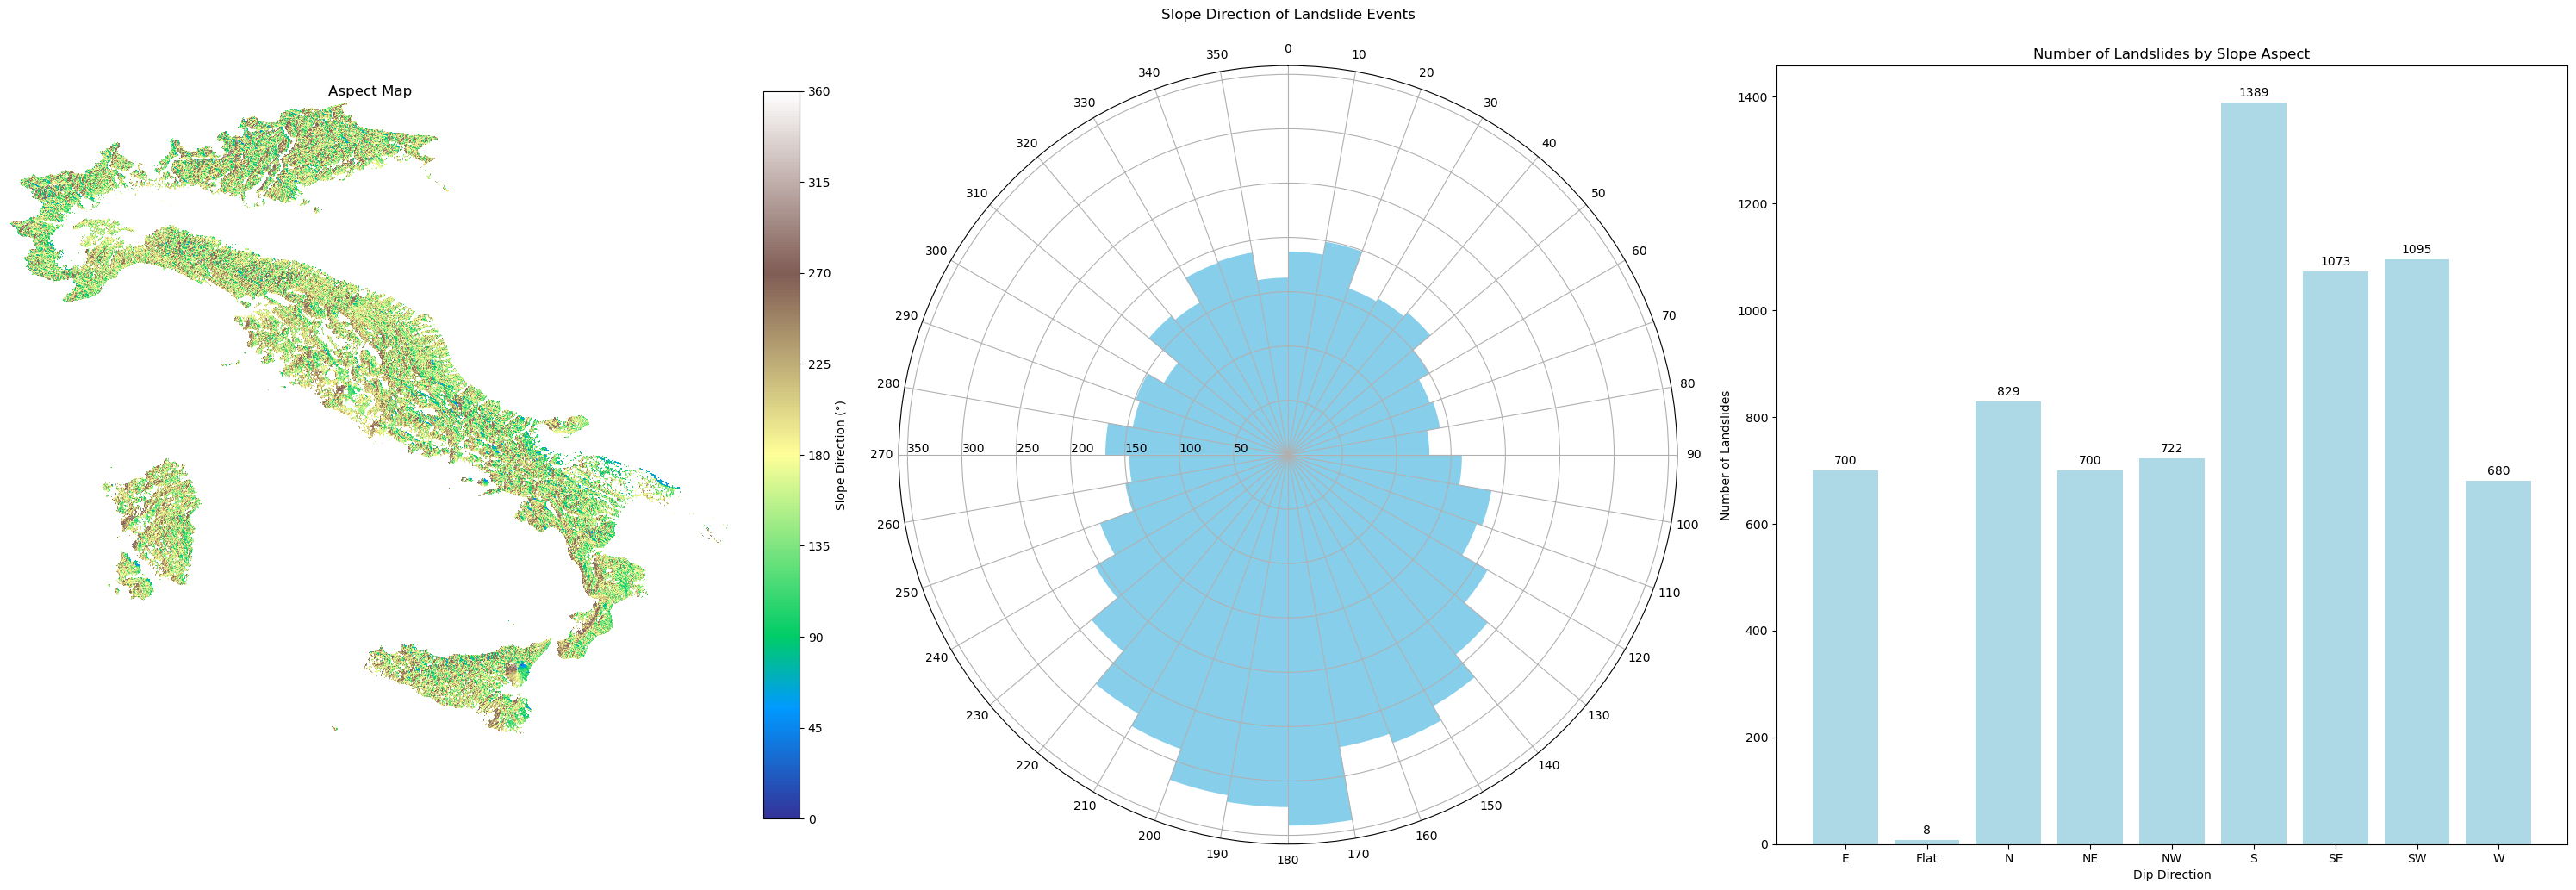

In [49]:
## Generate aspect raster from SRTM

#Define files and output
#workdir = os.getcwd() + '\\Documents\\data_analytics\\FraneItalia\\italy_dtm\\'
aspect_uncompressed = workdir + 'aspect_unc.tif'
aspect_path = workdir + 'aspect.tif'

# Command to generate aspect raster
cmd = f"gdaldem aspect {dem} {aspect_uncompressed} -compute_edges -s 111120"
# Execute command
subprocess.call(cmd, shell=True)

# Reduce file size of slope raster
compressor(aspect_uncompressed, aspect_path)

# Open slope raster
aspect = gdal.Open(aspect_path)
# Read raster into numpy array
aspect_array = aspect.GetRasterBand(1).ReadAsArray()

# Mask values < -1 (-1° slope indicates flat ground surface; Chen et al., 2020 https://doi.org/10.1007/s11069-020-03899-9) 
aspect_mask = np.ma.masked_less(aspect_array, -1)

#################################################################################################################
## Count number of landslide events per dip direction interval of 10°.

# Define list to store slope values
aspect_values = []

with rasterio.open(aspect_path) as f:
    affine = f.transform
    array = f.read(1) # Read band 1

    # Loop through df to get lat/long values 
    for index, row in df.iterrows():
        lat = row['lat']
        long = row['long']

        # Convert lat/long to row and column indices
        col, row = ~affine * (long, lat)
        row = int(row)
        col = int(col)

        # Check if lat/long are inside the raster array boundary
        if 0 <= row < array.shape[0] and 0 <= col < array.shape[1]:
            aspect_value = array[row, col]
        else:
            aspect_value = None

        # Add slope_value to slope_values
        aspect_values.append(aspect_value)

# Add to aspect column to df
df['aspect'] = aspect_values

# Create bins for aspect values in 10° intervals
bins = np.arange(0, 361, 10)
df['aspect_bin'] = pd.cut(df['aspect'], bins=bins, labels=bins[:-1])

# Compute histogram of aspect values
hist, bin_edges = np.histogram(aspect_values, bins=bins)
# Align bin_edges to center bars on each bin value
bar_theta = np.deg2rad((bin_edges[:-1] + bin_edges[1:]) / 2)

## Group values according to Chen et al 2020 classification
# Define bins and x-labels
dd_bin = [0, 22.5, 67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5, 360]
dip_dir = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']

# Bin the slope values and count occurrences in each bin
df['aspect_range'] = pd.cut(df['aspect'], bins=dd_bin, labels=dip_dir, right=False, ordered=False)

# Define 'flat' pixels where slope is 0 and aspect is -9999
df['aspect_range'] = df.apply(lambda row: 'Flat' if row['slope'] == 0 and row['aspect'] == -9999 else row['aspect_range'], axis=1)

dd_count = df['aspect_range'].value_counts().sort_index().reset_index()
dd_count.columns = ['aspect_range', 'count']
#################################################################################################################
## Plot

# Create figure and subplots
fig = plt.figure(figsize=(30, 10))

# Create a 1x2 grid using GridSpec
gs = GridSpec(nrows=1, ncols=3, figure=fig)

# 1. Aspect map
ax0 = fig.add_subplot(gs[0, 0])
cmap = plt.cm.terrain
cmap.set_bad(color='white')
im = ax0.imshow(aspect_mask, cmap=cmap, vmin=0, vmax=360)
cbar = fig.colorbar(im, ax=ax0, fraction=0.046, pad=0.04)
cbar.set_label('Slope Direction (°)')
cbar.set_ticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
cbar.set_ticklabels(['0', '45', '90', '135', '180', '225', '270', '315', '360'])
ax0.set_title('Aspect Map')
ax0.axis('off')

# 2. Rose Diagram
ax1 = fig.add_subplot(gs[0, 1], projection='polar')
bars = ax1.bar(bar_theta, hist, width=np.deg2rad(10), align='center', color='skyblue')
ax1.set_theta_zero_location('N')  # North as the starting point
ax1.set_theta_direction(-1)  # Clockwise direction
ax1.set_rlabel_position(-90)  # Radial labels on the left

ticks = np.arange(0, 360, 10)
ax1.set_xticks(np.deg2rad(ticks))  # Set ticks intervals
ax1.set_xticklabels([str(tick) for tick in ticks])  
ax1.set_title('Slope Direction of Landslide Events', pad=20)
ax1.grid(True)

# 3. Bar Chart
ax2 = fig.add_subplot(gs[0, 2])
bars = ax2.bar(dd_count['aspect_range'], dd_count['count'], color='lightblue')
ax2.set_xlabel('Dip Direction')
ax2.set_ylabel('Number of Landslides')
ax2.set_title('Number of Landslides by Slope Aspect')
ax2.set_xticklabels(dd_count['aspect_range'])

# Bar annotation
for bar in bars:
    yval = bar.get_height()
    ax2.annotate(f'{yval}', xy=(bar.get_x() + bar.get_width() / 2, yval),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
# Show plot
plt.tight_layout()
fig.show()


#### Soil Saturation
As water infiltrates soil, the pore spaces between soil grains fill with water, raising pore pressure and diminishing soil cohesion and stability, which can culminate in slope failure. Scientists analyze the impact of saturation on soils using various properties such as bulk density, porosity, soil cohesion, plasticity, hydraulic conductivity, infiltration, groundwater depth, and transmissivity. However, on a regional scale, assessing spatial variations of these parameters proves challenging. Therefore, proxies are employed because they offer indirect indicators that are more feasible to measure across extensive geographical areas.

The Compound Topographic Index (CTI), also known as the Topographic Wetness Index (TWI), is the most common hydrological proxy for soil saturation. It is defined as the natural logarithm of the ratio of the contributing area to the tangent of the slope ([Beven and Kirby, 1979](https://doi.org/10.1080/02626667909491834); [Moore et al., 1991](https://doi.org/10.1002/HYP.3360050103)). CTI is calculated using a digital elevation model (DEM) of the contributing area, which is determined based on the flow direction. Steep slopes are well-drained areas and thus have low CTI values. In contrast, generally flat or gently sloping terrain represents large contributing areas prone to water accumulation, leading to high CTI values ([Mattivi et al., 2019](https://doi.org/10.1186/s40965-019-0066-y)).

C:\Users\romercarlo\AppData\Local\Temp\ipykernel_28332\1592581417.py:128: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



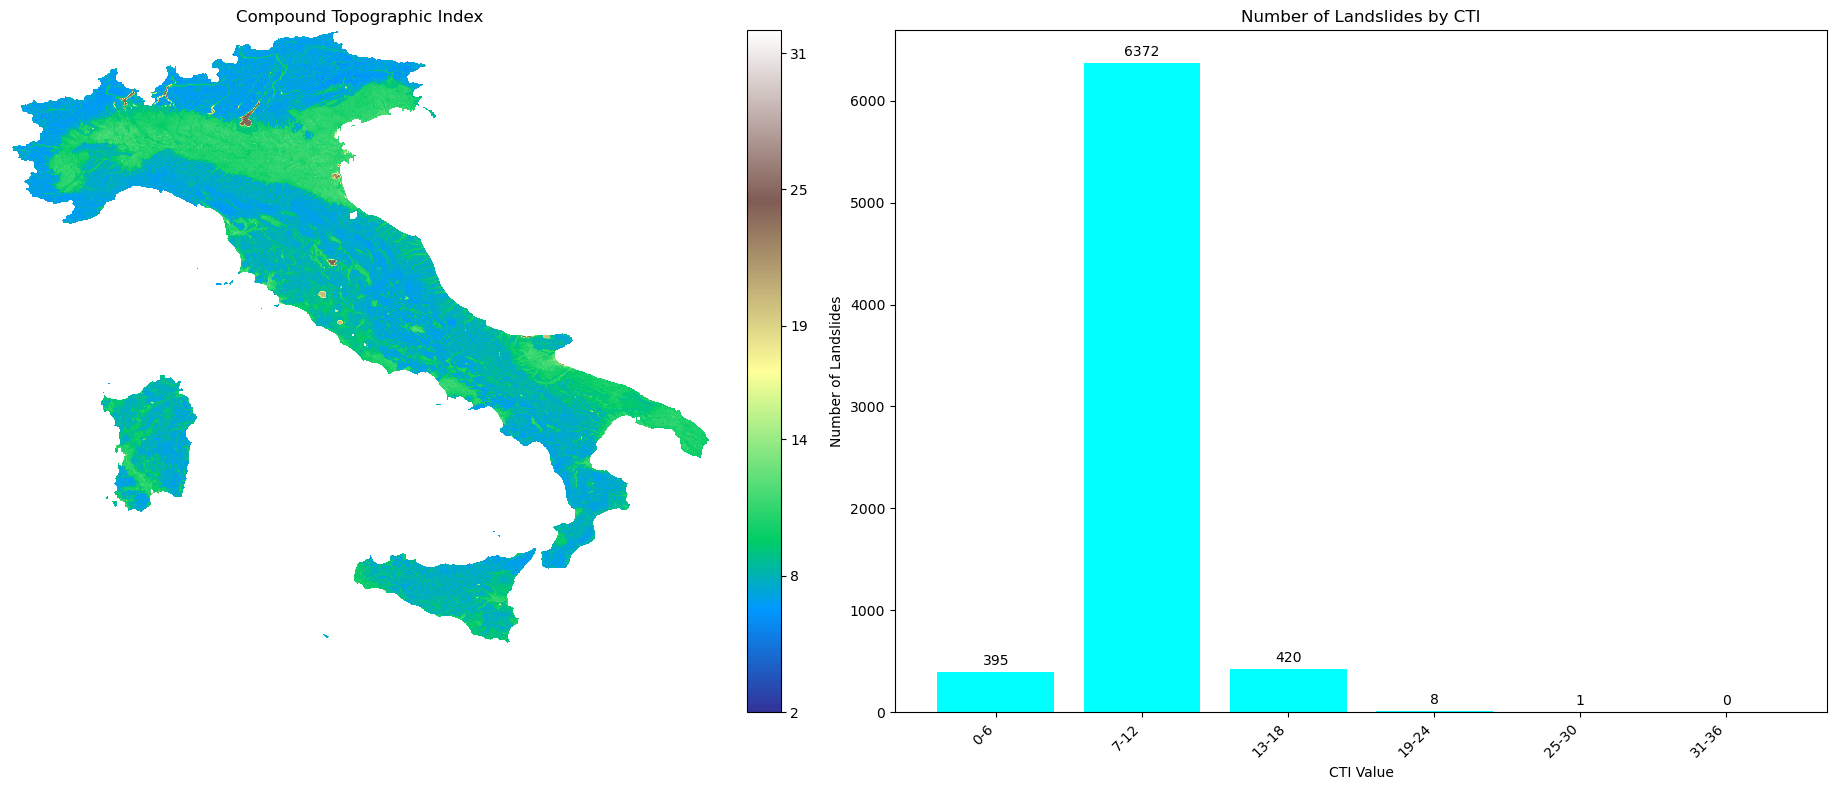

In [51]:
# Note: ArcGIS 10.1 was used to derive CTI from the DEM because it has yielded satisfactory results.
'''
import arcpy
import arcgisscripting, os
from arcpy import env
from arcpy.sa import *


# Create geoprocessor object
gp = arcgisscripting.create()
# Check Spatial Analyst license
arcpy.CheckOutExtension('Spatial')

# Set workspace and environment
workdir = os.chdir('') # The file path has been intentionally omitted to maintain privacy.
gp.workspace = workdir
env.workspace = workdir

# Set input and output variables
dtm = os.path.join(workdir, "dem.tif")
slope = os.path.join(workdir, "slope.tif") 
cti = os.path.join(workdir, "cti.tif")

# Step 1: Compute specific catchment area (SCA)
fdir = FlowDirection(Raster(dtm), "", "") # Flow direction
facc = FlowAccumulation(fdir, "", "") # Flow accumulation
sc_facc = (facc+1)*90 # Scaled flow accumulation

# Step 2: Calculate tangent of slope
outRas = Con(Raster(slope)==0, 0.00001, slope) # Replace 0° with 0.00001 to avoid infinity values in later step
slorad = outRas*math.pi/180 # Convert degrees to radians
slotan = Tan(slorad) # Compute tangent of slope

# Step 3: Generate CTI
twi = Ln(sc_facc/slotan)
twi.save(cti)

''';
#################################################################################
# Get CTI value of each landslide event
cti = os.path.join(workdir, 'italy_dtm', 'cti.tif')

cti_values = []

with rasterio.open(cti) as src:
    affine = src.transform
    cti_data = src.read(1) # Read 1st band
    #cti_meta = src.meta    # Read metadata
    nodata = src.nodata    # Identify NoData values
     
    # Mask NoData values
    masked_data = np.ma.masked_equal(cti_data, nodata)

    # Get minimum non-zero/non-negative CTI value
    min_value = masked_data[masked_data >= 0].min()
    # Get maximum CTI value
    max_value = masked_data.max()

    # Loop through df to get lat/long values
    for index, row in df.iterrows():
        lat = row['lat']
        long = row['long']

        # Convert lat/long to row and column indices
        col, row = ~affine * (long, lat)
        row = int(row)
        col = int(col)

        # Check if lat/long are inside the raster array boundary
        if 0 <= row <= cti_data.shape[0] and 0 <= col <= cti_data.shape[1]:
            cti_value = cti_data[row, col]
            cti_values.append(cti_value)
        else:
            cti_values.append(np.nan)  # If out of bounds, append NaN

# Add cti to df
df['cti'] = cti_values

#################################################################################

# Create figure and subplots
fig = plt.figure(figsize=(20, 8))

# Create a 1x2 grid using GridSpec
gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 1], figure=fig)

### 1. CTI map

ax0 = fig.add_subplot(gs[0, 0])
cmap = plt.cm.terrain
cmap.set_bad(color='white')
im = ax0.imshow(masked_data, cmap=cmap, vmin=math.floor(min_value), vmax=math.ceil(max_value))
bins = np.linspace(min_value, max_value, 6).astype(int) # Create bins for the color scale
cbar = fig.colorbar(im, ax=ax0, fraction=0.046, pad=0.04, ticks=bins)
#cbar.set_label('CTI')
ax0.set_title('Compound Topographic Index')
ax0.axis('off')

### 2. Bar chart

# Define bins
cti_bins = list(np.arange(0, 37, 6))

cti_labels = [] # List of cti bin labels 

# Bin the CTI values in multiples of 6
for i in range(len(cti_bins) - 1):
    lower_bound = int(cti_bins[i])
    if lower_bound == 0:
        upper_bound = int(cti_bins[i + 1]) 
        label = f"{lower_bound}-{upper_bound}"
        cti_labels.append(label)
    else:
        upper_bound = int(cti_bins[i + 1]) 
        label = f"{lower_bound + 1}-{upper_bound}"
        cti_labels.append(label)

# Bin the CTI values
df['cti_range'] = pd.cut(df['cti'], bins=cti_bins, labels=cti_labels, right=False)
cti_count = df['cti_range'].value_counts().sort_index().reset_index()
cti_count.columns = ['cti_range', 'count']

ax1 = fig.add_subplot(gs[0,1])
bars = ax1.bar(cti_count['cti_range'], cti_count['count'], color='cyan')
ax1.set_xlabel('CTI Value')
ax1.set_ylabel('Number of Landslides')
ax1.set_title('Number of Landslides by CTI')
ax1.set_xticklabels(cti_count['cti_range'], rotation=45, ha='right')

# Bar annotation
for bar in bars:
    yval = bar.get_height()
    ax1.annotate(f'{yval}', xy=(bar.get_x() + bar.get_width() / 2, yval),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

#### Surface Roughness
The roughness of the ground surface reflect multiple landslide characteristics including its size, type, activity, material properties, boundary conditions, runout, and age ([Goetz et al., 2014](https://doi.org/10.1002/esp.3630)). In computational landslide modeling, surface roughness is quantified using the Terrain Ruggedness Index (TRI), a parameter derived from DEMs. TRI measures surface roughness by evaluating elevation differences between adjacent cells ([Riley et al., 1999](https://download.osgeo.org/qgis/doc/reference-docs/Terrain_Ruggedness_Index.pdf); [Różycka et al., 2017](https://doi.org/10.1127/zfg_suppl/2016/0328)). A high values of TRI indicate significant terrain irregularity, which correlates with an increased potential for slope instability. In this notebook, quantitative measurement of surface roughness will be performed using the TRI calculation introduced by [Riley et al. (1999)](https://download.osgeo.org/qgis/doc/reference-docs/Terrain_Ruggedness_Index.pdf) due to its reliability and widespread acceptance in geomorphological and landslide hazard studies.

C:\Users\romercarlo\AppData\Local\Temp\ipykernel_28332\1821757823.py:105: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



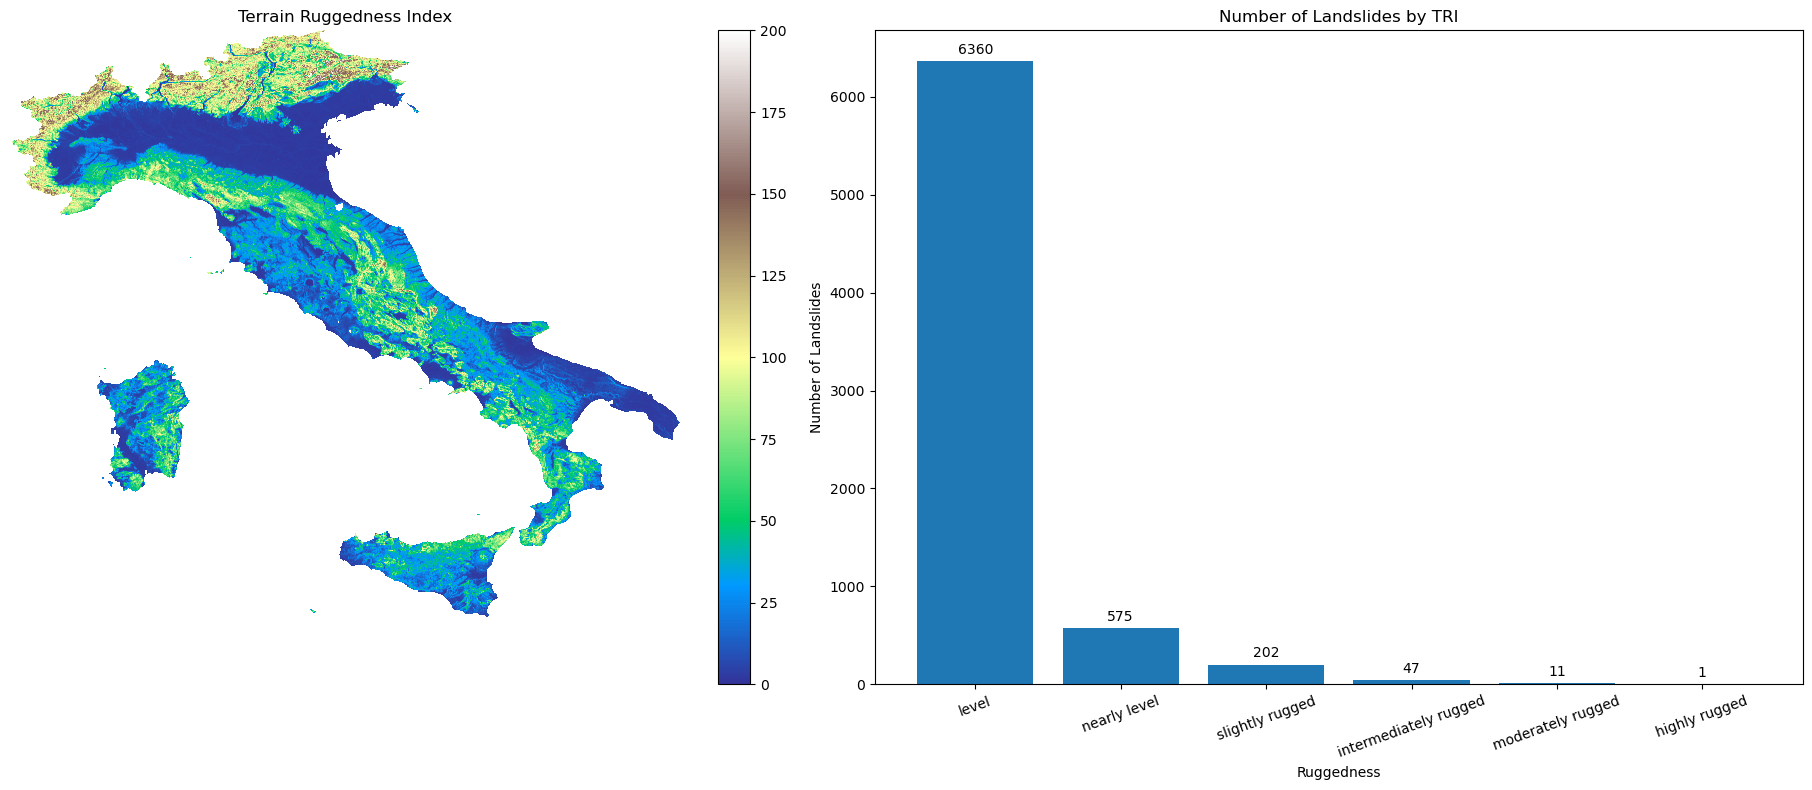

In [53]:
## Generate TRI raster from SRTM

#Define files and output
tri = os.path.join(workdir, 'italy_dtm', 'tri.tif')

# Command to generate slope raster
cmd = f"gdaldem TRI {dem} {tri} -compute_edges -s 111120" 
# Execute command
subprocess.call(cmd, shell=True)

#########################################################################################################
## Classify the ruggedness of each landslide event

# Extract TRI of each landslide event from raster
with rasterio.open(tri) as raster:
    affine = raster.transform
    array = raster.read(1) # Read band 1
    nodata = raster.nodata    # Identify NoData values
    
    # Mask NoData values
    tri_mask = np.ma.masked_equal(array, nodata)

    # Get min & max value of raster
    tri_min = tri_mask.min()
    tri_max = tri_mask.max()

    # Define list to store TRI values
    tri_values = []
    # Loop through df to get lat/long values
    for index, row in df.iterrows():
        lat = row['lat']
        long = row['long']

        # Convert lat/long to row and column indices
        col, row = ~affine * (long, lat)
        row = int(row)
        col = int(col)

        # Check if lat/long are inside the raster array boundary
        if 0 <= row < array.shape[0] and 0 <= col < array.shape[1]:
            tri_value = tri_mask[row, col]
            tri_values.append(tri_value)
        else:
            tri_values.append(np.nan)  # If out of bounds, append NaN

# Optional: Add tri column to df
df['tri'] = tri_values

# Categorize TRI values following Riley et al. (1999) classification

# Define list to store TRI class
tri_class = []

for value in tri_values:
    if 0 <= value <= 80:
        tri_class.append('level')
    elif 80 < value <= 116:
        tri_class.append('nearly level')
    elif 116 < value <= 161:
        tri_class.append('slightly rugged')
    elif 161 < value <= 239:
        tri_class.append('intermediately rugged')
    elif 239 < value <= 497:
        tri_class.append('moderately rugged')
    elif 497 < value <= 958:
        tri_class.append('highly rugged')
    elif 958 < value <= 4367:
        tri_class.append('extremely rugged')
    else:
        tri_class.append(np.nan)

# Add tri_class to df
df['tri_class'] = tri_class

#################################################################################

# Create figure and subplots
fig = plt.figure(figsize=(20, 8))

# Create a 1x2 grid using GridSpec
gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 1], figure=fig)

### 1. TRI map

tri_cutoff = [0, 25, 50, 75, 100, 125, 150, 175, 200]

ax0 = fig.add_subplot(gs[0, 0])
cmap = plt.cm.terrain
cmap.set_bad(color='white')
im = ax0.imshow(tri_mask, cmap=cmap, vmin=tri_min, vmax=200)
cbar = fig.colorbar(im, ax=ax0, fraction=0.046, pad=0.04)
cbar.set_ticks(tri_cutoff)
cbar.set_ticklabels(list(map(str, tri_cutoff)))
ax0.set_title('Terrain Ruggedness Index')
ax0.axis('off')

### 2. Bar chart
tri_count = df[['tri_class']].value_counts().reset_index()

ax1 = fig.add_subplot(gs[0,1])
bars = ax1.bar(tri_count['tri_class'], tri_count['count'])
ax1.set_xlabel('Ruggedness')
ax1.set_ylabel('Number of Landslides')
ax1.set_title('Number of Landslides by TRI')
ax1.set_xticklabels(tri_count['tri_class'], rotation=20, ha='center')

# Bar annotation
for bar in bars:
    yval = bar.get_height()
    ax1.annotate(f'{yval}', xy=(bar.get_x() + bar.get_width() / 2, yval),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

#### Slope Position

Slope position refers to the location of a point on the landscape relative to its surrounding topography. It indicates a point on different parts of topographic landforms, which respond differently to landslide-triggering mechanisms. For example, landslide occurrence is high on ridges due to higher seismic amplification caused by earthquakes ([Densmore and Hovius, 2000](https://doi.org/10.1130/0091-7613(2000)28<371:TFOBL>2.0.CO;2); [Meunier et al., 2008](https://doi.org/10.1016/j.epsl.2008.07.020)) while rainfall-induced landslides tend to occur near footslopes as water tend to accumulate in these areas ([Rault et al., 2019](https://doi.org/10.5194/esurf-7-829-2019)). Therefore, slope position plays a crucial role in determining the susceptibility of different parts of hillslopes to landslides.

In this notebook, slope position is measured using Topographic Position Index (TPI), which is calculated as the difference between the elevation of a central point and the mean elevation of its neighbors ([Weiss, 2001](https://www.jennessent.com/downloads/TPI-poster-TNC_18x22.pdf)). Positive TPI values represent higher elevations compared to their surroundings (e.g., ridges), while negative values represent lower locations (e.g., valleys). Near-zero TPI values may represent either flat areas or areas of constant slope. Neighborhood size is set to 300m ([Weiss, 2001](https://www.jennessent.com/downloads/TPI-poster-TNC_18x22.pdf); [Emberson et al., 2022]( https://doi.org/10.5194/nhess-22-1129-2022
)) radius because the SRTM is notdetailed enough to reveal smaller topographic features. 


C:\Users\romercarlo\AppData\Local\Temp\ipykernel_28332\3440064171.py:143: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



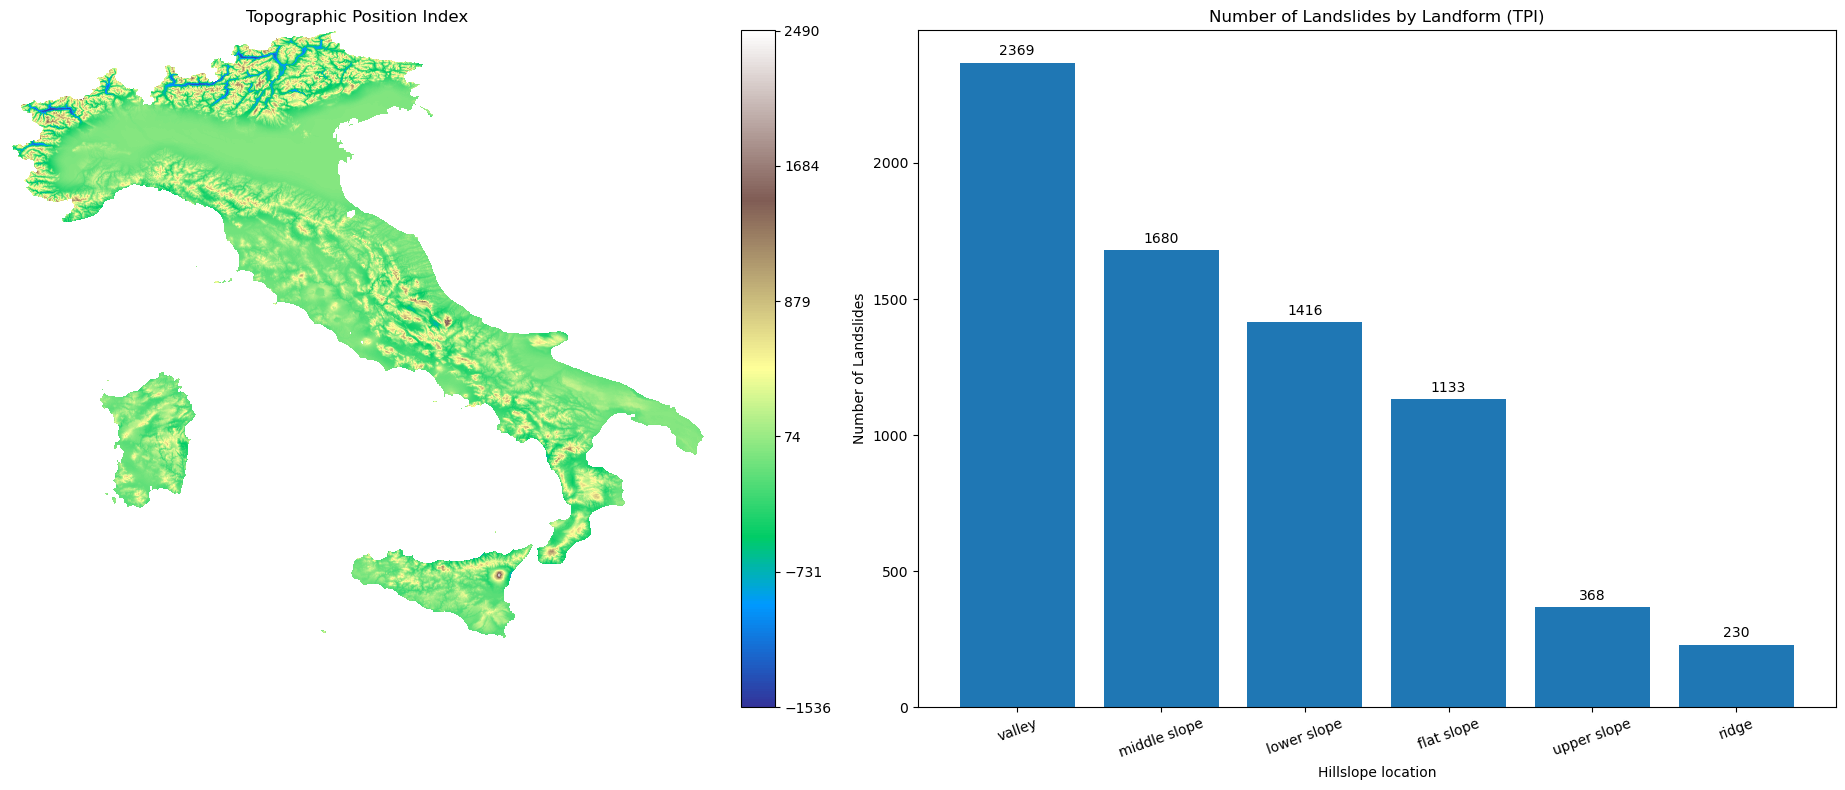

In [55]:
# Note: ArcGIS 10.1 was used to derive TPI from the DEM.
'''
import arcpy
import arcgisscripting, os
from arcpy import env
from arcpy.sa import *
import math

# Create geoprocessor object
gp = arcgisscripting.create()
# Check Spatial Analyst license
arcpy.CheckOutExtension('Spatial')

# Set workspace and environment
workdir = 'C:\\Users\\romercarlo\\Documents\\data_analytics\\FraneItalia' # The file path has been intentionally omitted to maintain privacy.
os.chdir(workdir)
gp.workspace = workdir
env.workspace = workdir

# Set input and output variables
dtm = os.path.join(workdir, "italy_dtm", "dem.tif")
slope = os.path.join(workdir, "italy_dtm", "slope.tif")
slope = Raster(slope) # Define slope as raster
italy_shp = os.path.join(workdir, "italy_Italy_Country_Boundary.shp") # Country boundary shapefile
table = os.path.join(workdir, "italy_dtm", "table") # TPI statistics table

# Step 1: Compute tpi300
mean_300m = FocalStatistics(dtm, NbrCircle(300,"CELL"), "MEAN", "DATA")
tpi300 = dtm - mean_300m
tpi300.save("tpi300.tif")
tpi300 = Raster(tpi300) # Define TPI as raster

# Step 2: Obtain the standard deviation of TPI raster
tpi_stat = ZonalStatisticsAsTable(italy_shp, "FID", tpi300, table, "DATA", "ALL")
stdev = next(row[0] for row in arcpy.da.SearchCursor(table, ["STD"])) # Get value of standard deviation

# Step 2: Classify TPI values according to Weiss (2001)
tpi_class = Con(tpi300 > std_value, 1, # Ridge
                        Con((tpi300 > 0.5 * std_value) & (tpi300 <= std_value), 2, # Upper slope
                            Con((tpi300 > -0.5 * std_value) & (tpi300 <= 0.5 * std_value) & (slope > 5), 3, # Middle slope
                                Con((tpi300 >= -0.5 * std_value) & (tpi300 <= 0.5 * std_value) & (slope <= 5), 4, # Flat slope
                                    Con((tpi300 >= -1.0 * std_value) & (tpi300 < -0.5 * std_value), 5, # Lower slope
                                        Con(tpi300 < -1.0 * std_value, 6, 0)))))) # Valley

# Remove class 0 since its not in Weiss (2001) classification
tpi_class = SetNull(tpi_class == 0, tpi_class)

tpi_class.save(os.path.join(workdir, "italy_dtm", "tpi_class.tif"))
''';

#################################################################################
## Classify the topographic position of each landslide event

tpi = os.path.join(workdir, "italy_dtm", "tpi300.tif")
tpi_class = os.path.join(workdir, "italy_dtm", "tpi_class.tif")

# Open TPI raster for visualization
with rasterio.open(tpi) as raster:
    affine = raster.transform
    array = raster.read(1) # Read band 1
    nodata = raster.nodata    # Identify NoData values
    
    # Mask NoData values
    tpi_mask = np.ma.masked_equal(array, nodata)

    # Get min & max value of raster
    tpi_min = tpi_mask.min()
    tpi_max = tpi_mask.max()

# Extract TPI class of each landslide event from raster
with rasterio.open(tpi_class) as raster:
    tpiclass_affine = raster.transform
    tpiclass_array = raster.read(1) # Read band 1
    tpiclass_nodata = raster.nodata

    # Define list to store TPI class
    tpiclass = []
    
    # Loop through df to get lat/long values
    for index, row in df.iterrows():
        lat = row['lat']
        long = row['long']

        # Convert lat/long to row and column indices
        col, row = ~affine * (long, lat)
        row = int(row)
        col = int(col)

        # Check if lat/long are inside the raster array boundary
        if 0 <= row < tpiclass_array.shape[0] and 0 <= col < tpiclass_array.shape[1]:
            tpi = tpiclass_array[row, col]
            tpiclass.append(tpi)
        else:
            tpiclass.append(np.nan)  # If out of bounds, append NaN

# Define list to store landform description of TPI class
landform = []

for value in tpiclass:
    if value == 1:
        landform.append('ridge')
    elif value == 2:
        landform.append('upper slope')
    elif value == 3:
        landform.append('middle slope')
    elif value == 4:
        landform.append('flat slope')
    elif value == 5:
        landform.append('lower slope')
    elif value == 6:
        landform.append('valley')
    else:
        landform.append(np.nan)

# Add tri_class to df
df['tpi_class'] = landform
#################################################################################
# Create figure and subplots
fig = plt.figure(figsize=(20, 8))

# Create a 1x2 grid using GridSpec
gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 1], figure=fig)

### 1. TPI map

ax0 = fig.add_subplot(gs[0, 0])
cmap = plt.cm.terrain
cmap.set_bad(color='white')
im = ax0.imshow(tpi_mask, cmap=cmap, vmin=math.floor(tpi_min), vmax=math.ceil(tpi_max))
tpi_bins = np.linspace(tpi_min, tpi_max, 6).astype(int)
cbar = fig.colorbar(im, ax=ax0, fraction=0.046, pad=0.04, ticks=tpi_bins)
ax0.set_title('Topographic Position Index')
ax0.axis('off')

### 2. Bar chart
tpi_count = df[['tpi_class']].value_counts().reset_index()

ax1 = fig.add_subplot(gs[0,1])
bars = ax1.bar(tpi_count['tpi_class'], tpi_count['count'])
ax1.set_xlabel('Hillslope location')
ax1.set_ylabel('Number of Landslides')
ax1.set_title('Number of Landslides by Landform (TPI)')
ax1.set_xticklabels(tpi_count['tpi_class'], rotation=20, ha='center')

# Bar annotation
for bar in bars:
    yval = bar.get_height()
    ax1.annotate(f'{yval}', xy=(bar.get_x() + bar.get_width() / 2, yval),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

#### Drainage Erosion

Intense rainfall, high weathering rates, and slope materials with low shear strength are key preparatory factors that increase the risk of landslides ([Claessens et al., 2007](https://doi.org/10.1016/j.earscirev.2012.02.006)). Heavy rains saturate the soil, reducing its cohesion and increasing its weight. As water flows down the hillslope, it erodes the the surface and accumulates sediments, further increasing the load on the slope. This added weight and reduced soil strength are critical in triggering landslides.

Understanding and quantifying the erosion potential of water flow are crucial for predicting and mitigating landslides. One effective way to measure this potential is by using the Stream Power Index (SPI), a widely used parameter in geomorphology that helps analyze the erosive power of flowing water ([Moore et al., 1991](https://doi.org/10.1002/HYP.3360050103)). It takes into account factors such as the slope gradient and the amount of water flow, providing valuable insights into sediment yield and the time it takes for water to concentrate in a particular area ([Okoli et al., 2023](https://doi.org/10.3390/geosciences13020034)). The index is calculated as the product of the specific catchment area and the tangent of the slope in degrees ([Yilmaz, 2009](https://doi.org/10.1016/j.cageo.2008.08.007); [Mahalingam et al., 2016](http://dx.doi.org/10.1080/19475705.2016.1172520); [Chen et al. 2020](https://doi.org/10.1007/s11069-020-03899-9)). High SPI values indicate areas with significant potential for erosion and sediment transport, such as steep and narrow drainages where water flow is concentrated ([Abu El-Magd et al., 2021](https://doi.org/10.1007/s12665-021-10013-0); [Barman et al., 2023](https://doi.org/10.1016/j.nhres.2023.06.006)), making them prone to landslide initiation. Conversely, low SPI values indicate areas with low erosive power, such as flat or gently sloping regions where water flow is less concentrated. For visualization, SPI is divided into four classes similar to the work of [Oh and Pradhan (2011)](https://doi.org/10.1016/j.cageo.2010.10.012
 for datasets with very low SPI values: 0-0.095, 0.096-1.917, 1.918-2.876, and >2.877.)


C:\Users\romercarlo\AppData\Local\Temp\ipykernel_28332\1363088213.py:83: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



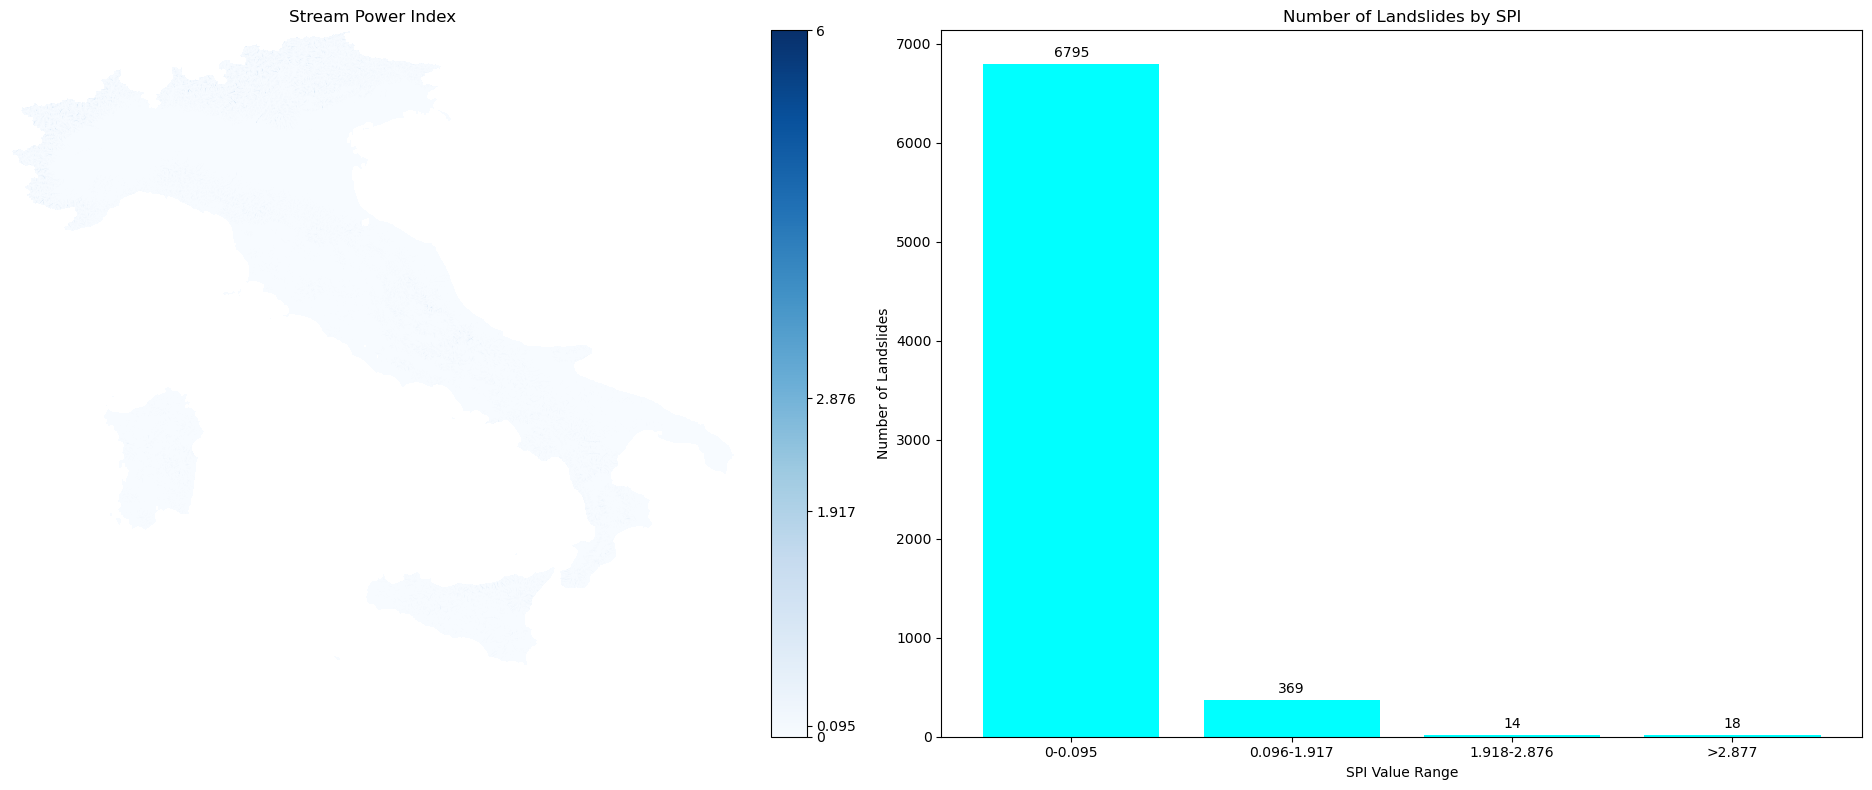

In [57]:
# Note: ArcGIS 10.1 was used to derive SPI

'''
# Rasters used for generating SPI are the same as CTI

# SPI equation from Moore et al. (1991)
# SPI = specific contributing area*[tan(slope)]
spi = facc*90*slotan # Where 90 is the cell size of dem
spi = spi/10000 # To scale down values of output raster
spi.save("spi.tif")
''';

#################################################################################
# Get CTI value of each landslide event
spi = os.path.join(workdir, 'italy_dtm', 'spi.tif')

with rasterio.open(spi) as src:
    affine = src.transform
    spi_data = src.read(1)
    nodata = src.nodata

    # Mask NoData values
    spi_masked = np.ma.masked_equal(spi_data, nodata)

    spi_class = []
    # Loop through df to get lat/long values
    for index, row in df.iterrows():
        lat = row['lat']
        long = row['long']

        # Convert lat/long to row and column indices
        col, row = ~affine * (long, lat)
        row = int(row)
        col = int(col)

        # Check if lat/long are inside the raster array boundary
        if 0 <= row < spi_masked.shape[0] and 0 <= col < spi_masked.shape[1]:
            spi = spi_masked[row, col]
            spi_class.append(spi)
        else:
            spi_class.append(np.nan)  # If out of bounds, append NaN

df['spi'] = spi_class

#################################################################################

# Create figure and subplots
fig = plt.figure(figsize=(20, 8))

# Create a 1x2 grid using GridSpec
gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 1], figure=fig)

### 1. SPI map

oh_class = [0, 0.095, 1.917, 2.876, 6]

ax0 = fig.add_subplot(gs[0, 0])
cmap = plt.cm.Blues
cmap.set_bad(color='white')
im = ax0.imshow(spi_masked, cmap=cmap, vmin=math.floor(df['spi'].min()), vmax=math.ceil(df['spi'].max()))
cbar = fig.colorbar(im, ax=ax0, fraction=0.046, pad=0.04)
cbar.set_ticks(oh_class)
cbar.set_ticklabels(list(map(str, oh_class)))
ax0.set_title('Stream Power Index')
ax0.axis('off')

### 2. Bar chart

# Bin the SPI values using oh_class
spi_labels = ['0-0.095', '0.096-1.917', '1.918-2.876', '>2.877']
df['spi_range'] = pd.cut(df['spi'], bins=oh_class, labels=spi_labels, right=False)

# Count the occurrences in each bin
spi_count = df['spi_range'].value_counts().sort_index().reset_index()
spi_count.columns = ['spi_range', 'count']

# Plot the bar chart
ax1 = fig.add_subplot(gs[0,1])
bars = ax1.bar(spi_count['spi_range'], spi_count['count'], color='cyan')
ax1.set_xlabel('SPI Value Range')
ax1.set_ylabel('Number of Landslides')
ax1.set_title('Number of Landslides by SPI')
ax1.set_xticklabels(spi_labels)

# Bar annotation
for bar in bars:
    yval = bar.get_height()
    ax1.annotate(f'{yval}', xy=(bar.get_x() + bar.get_width() / 2, yval),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

##### Insights
***
- With the exception of 4 events, all landslides fall within the 0-5 SPI value range indicating that majority of the landslides occur in areas with low stream power or in drier conditions.

### Landslide Susceptibility

It is commonly assumed that future landslide events will occur under conditions similar to those of past landslides ([Lee and Talib, 2005](https://doi.org/10.1007/s00254-005-0019-x); [Yilmaz, 2009](https://doi.org/10.1016/j.cageo.2008.08.007)). Thus, landslide susceptibility can be quantitatively assessed through the analysis of topographic conditions (or conditioning factor) using the Frequency Ratio (FR) method. This statistical approach is widely used in landslide susceptibility mapping to evaluate and quantify the relationship between conditioning factors and  landslide occurrences (e.g. [Lee and Talib, 2005](https://doi.org/10.1007/s00254-005-0019-x); [Yilmaz, 2009](https://doi.org/10.1016/j.cageo.2008.08.007); [Chen et al. 2020](https://doi.org/10.1007/s11069-020-03899-9); [Nakileza and Nedala, 2020](https://doi.org/10.1186/s40677-020-00160-0); [Mandal et al., 2024](https://doi.org/10.1007/s44288-024-00055-9)). 

The frequency ratio method is particularly suitable for statistical landslide analysis of coarser resolution images including SRTM ([Chen et al. 2020](https://doi.org/10.1007/s11069-020-03899-9)). FR represents the ratio of the probability of landslide occurrence within a specific class of a causative factor to the probability of that class occurring across the entire study area ([Bonham-Carter, 1994](https://doi.org/10.1016/B978-0-08-041867-4.50001-1); [Lee and Talib, 2005](https://doi.org/10.1007/s00254-005-0019-x)), as expressed by the equation:

$$\large{\text{FR} = \frac{\frac{\text{Number of landslides in a specific conditioning factor}}{\text{Total number of landslides}}}{\frac{\text{Area of the specific conditioning factor}}{\text{Total area of the study area}}}}$$

An FR value of 1 indicates an average correlation between the factor class and landslide occurrence, while values less than 1 suggest a lower correlation and values greater than 1 indicate a higher correlation ([Lee and Talib, 2005](https://doi.org/10.1007/s00254-005-0019-x)).

In [60]:
# List of table for FR processing

# slope -- slope_count.columns = ['slope_range', 'count'] -- 6 cols
# aspect -- dd_count.columns = ['aspect_range', 'count'] -- 9 cols
# cti -- cti_count.columns = ['cti_range', 'count'] -- 6 cols
# tri -- tri_count.columns = ['tri_class', 'count'] -- 6 cols
# tpi -- tpi_count.columns = ['tpi_class', 'count'] -- 6 cols
# spi -- spi_count.columns = ['spi_range', 'count'] -- 9 cols

In [61]:
def frequency_ratio(input_raster, input_dataframe, input_bins=None, format_numbers=True):
    """
    This function computes for the frequency ratio of input table.

    Parameters:
    input_raster (str): The file path of the input raster.
    input_dataframe (pandas dataframe): Name of landslide conditioning factor table.
    nput_bins (list, optional): Bins to classify raster values (required for handling TPI dataframe)

    Returns:
    pandas.DataFrame: Updated DataFrame with pixel counts, percentages, and frequency ratios.
    """
    # Check if 'tpi_class' in input_dataframe
    is_tpi_class = 'tpi_class' in input_dataframe.columns.values
    
    ## If the raster is not 'tpi_class' and input_bins is None, raise an error
    if not is_tpi_class and input_bins is None:
        raise ValueError("input_bins is required for frequency ratio computation other than TPI.")

    ## Compute numerator of Frequency Ratio equation
    input_dataframe.rename(columns={'count': 'No. of Landslides'}, inplace=True)
    landslides_total = input_dataframe['No. of Landslides'].sum() # Compute total of landslide column
    # Percentage of landslides per domain
    input_dataframe['% of landslides'] = input_dataframe['No. of Landslides']/landslides_total * 100

    ## Compute denominator of FR equation
    # Count number of pixels per domain
    with rasterio.open(input_raster) as raster:
        raster_array = raster.read(1) # Read band 1
        # Mask no data values
        raster_array = np.ma.masked_equal(raster_array, raster.nodata)
        valid_pixels = raster_array.compressed()

        # Case 1: For TPI due to discrete raster values        
        if is_tpi_class:
            # Define dictionary of TPI classes
            tpi_class_dict =  {1: 'ridge', 2: 'upper slope', 3: 'middle slope', 4: 'flat slope', 5: 'lower slope', 6: 'valley'}
            
            pixel_counts = np.bincount(valid_pixels.astype(int), minlength=7)  # Minlength 7 to include index 1-6 from TPI raster
            pixels = pixel_counts[1:] # Ignore index 0 (corresponds to value 0 or no-data)

            # Map pixel counts to TPI classes
            pixel_dict = {tpi_class_dict[i]: pixels[i-1] for i in range(1, 7)}

            for tpi_class, count in pixel_dict.items():
                input_dataframe.loc[input_dataframe['tpi_class'] == tpi_class, 'pixel_count'] = count

        # Case 2: For raster with continuous raster values
        else:
            px_class = np.digitize(raster_array, input_bins, right=True) # Classify pixels into bins
            pixels = np.bincount(px_class.flatten(), minlength=len(input_bins) + 1)  # Count pixels per bin
        
            # Ensure pixel count matches the number of rows in the DataFrame
            if len(pixels) - 1 == len(input_dataframe):  # Ensure pixel counts match rows
                input_dataframe['pixel_count'] = pixels[1:]  # Exclude no-data bin
            else:
                # Adjust if lengths do not match
                input_dataframe['pixel_count'] = pixels[1:len(input_dataframe) + 1]

    # Compute total of pixel_count column
    pixel_total = input_dataframe['pixel_count'].sum() 
    # Percentage of pixels per domain
    input_dataframe['% of pixels'] = input_dataframe['pixel_count']/pixel_total * 100

    ## Frequency Ratio
    input_dataframe['frequency_ratio'] = input_dataframe['% of landslides'] / input_dataframe['% of pixels']

    # Round off decimals to hundredths place
    input_dataframe['% of landslides'] = input_dataframe['% of landslides'].round(2)
    input_dataframe['% of pixels'] = input_dataframe['% of pixels'].round(2)
    input_dataframe['frequency_ratio'] = input_dataframe['frequency_ratio'].round(2)

    # Add thousands separators
    input_dataframe['No. of Landslides'] = input_dataframe['No. of Landslides'].apply(lambda x: f"{x:,.0f}")
    input_dataframe['pixel_count'] = input_dataframe['pixel_count'].apply(lambda x: f"{x:,.0f}")

    return input_dataframe


In [62]:
count_list = [slope_count, dd_count, cti_count, tri_count, tpi_count, spi_count]

for dataframe in count_list:
    column_names = list(dataframe.columns.values) # get list of column names
    ls_factor = column_names[0].split('_') # split name of column 1
    if ls_factor[0] == 'slope':
        in_raster = slope
        in_bins = slope_bins
        frequency_ratio(in_raster, dataframe, in_bins)
    elif ls_factor[0] == 'aspect':
        in_raster = aspect_path
        in_bins = dd_bin
        frequency_ratio(in_raster, dataframe, in_bins)
    elif ls_factor[0] == 'cti':
        in_raster = cti
        in_bins = cti_bins
        frequency_ratio(in_raster, dataframe, in_bins)
    elif ls_factor[0] == 'tri':
        in_raster = tri
        in_bins = [0, 80, 116, 161, 239, 497, 958] # Omitted threshold values for extremely rugged
        frequency_ratio(in_raster, dataframe, in_bins)
    elif ls_factor[0] == 'tpi':
        in_raster = tpi_class
        frequency_ratio(in_raster, dataframe)
    elif ls_factor[0] == 'spi':
        in_raster = os.path.join(workdir, 'italy_dtm', 'spi.tif')
        in_bins = oh_class
        frequency_ratio(in_raster, dataframe, in_bins)
    else:
        pass

    # Format dataframe
    formatted_table = tabulate(dataframe, headers='keys', tablefmt='pipe', showindex=False)
    print(formatted_table)

| slope_range   | No. of Landslides   |   % of landslides | pixel_count   |   % of pixels |   frequency_ratio |
|:--------------|:--------------------|------------------:|:--------------|--------------:|------------------:|
| < 10          | 4,696               |             65.26 | 30,338,096    |         64.27 |              1.02 |
| 10–15         | 1,194               |             16.59 | 6,405,378     |         13.57 |              1.22 |
| 15–20         | 642                 |              8.92 | 4,048,110     |          8.58 |              1.04 |
| 20–25         | 363                 |              5.04 | 2,817,660     |          5.97 |              0.85 |
| 25–30         | 169                 |              2.35 | 1,869,532     |          3.96 |              0.59 |
| >30           | 132                 |              1.83 | 1,728,752     |          3.66 |              0.5  |
| aspect_range   | No. of Landslides   |   % of landslides | pixel_count   |   % of pixels |   frequency

##### Results and Discussion
***
###### Slope Angle
- From 2010 to 2020, landslides predominantly occurred on slopes less than 20°, with FR ranging from 1.02 to 1.22. This result is consistent with the observations of [Borgomeo et al. (2014)](https://doi.org/10.1016/j.geomorph.2014.08.004) where 50% of all landslides occur on 10°-15° slopes, despite this range represent only 30% of hillslope gradients in their study area. Similarly, [Bamutze (2019)](https://doi.org/10.1016/B978-0-12-815821-0.00010-2) observed that landslides are more prevalent on 11°-31° slope range in Uganda's Elgon region.
- A notable decline in landslide events is observed for steeper slopes, particularly those exceeding 30°. This is likely due to the predominance of exposed bedrock, which is more geologically stable (e.g., [Donnarumma et al., 2013](https://doi.org/10.1007/978-3-642-31325-7_56)). In contrast, lower slope gradients are more susceptible to landslides due to water accumulation, especially during colder, wetter seasons.

###### Slope Aspect
- All slope directions except NE and NW exhibit a high frequency of landslides. Slopes facing the southern half of the compass (SW to SE) are especially prone to instability, likely due to intense cycles of wetting and drying ([Capitani et al., 2013](https://doi.org/10.1016/j.crte.2013.11.002)).
    - Periodic wetting and drying of slope materials can cause expansion and contraction, particularly in superficial layers ([Lulli and Rochetti, 1973](https://agris.fao.org/search/en/providers/123819/records/64735cd753aa8c8963090d90); [Vittorini, 1977](https://www.bsgi.it/index.php/bsgi/article/download/6209/5527), [1979](https://dialnet.unirioja.es/servlet/articulo?codigo=6006663)). Over time, thermal fluctuations exacerbate drying and cracking, weakening the slope and increasing landslide susceptibility.
    - Lack of vegetation on slopes facing E to S may contribute to landslide triggers, as reduced evapotranspiration impairs plant growth, leaving soil more vulnerable during intense rainfall events ([Mario et al., 2023](https://doi.org/10.1080/17445647.2022.2137065)).
- Landslides occurring in north-facing slopes are attributed to their shadier, colder, and more humid conditions ([Magliulo et al., 2008](https://doi.org/10.1007/s11069-008-9230-x); [Yalcin, 2008](https://doi.org/10.1016/j.catena.2007.01.003); [Bernardik et al., 2010](https://doi.org/10.1016/j.pce.2009.12.002); [Piacentini et al., 2012](https://doi.org/10.1016/j.geomorph.2012.02.003); [Yalcin et al., 2011](https://doi.org/10.1016/j.catena.2011.01.014)). In areas such as Southern Italy, even with denser vegetation, landslides occur frequently as high precipitation oversaturates the soil ([Mario et al., 2023](https://doi.org/10.1080/17445647.2022.2137065)).

###### Soil Saturation (CTI)
- Landslides predominantly occur in areas with CTI values ranging from 6 to 12, with a frequency ratio of 1.04. This finding is consistent with [Nseka et. al. (2019)](https://doi.org/10.1007/s11069-019-03787-x) where most landslides in Uganda's Kigezi Highlands fall on CTI values of 8-18.
- Saturation increases downslope and peaks at valley bottoms due to the accumulation of water from upslope areas ([Chi et al., 2009](https://doi.org/10.1016/S1002-0160(09)60127-2); [Grabs et al., 2009](https://doi.org/10.1016/j.jhydrol.2009.03.031)). In Italy, the lower slope gradient observed in many landslide events may result from oversaturation at the foot slopes, where water cannot easily drain away.

###### Surface Roughness (TRI)
- Results show that levelled and moderately rugged terrain have the highest density of landslides, with FRs of 1.05 and 1.01, respectively.
- Highly rugged terrain exhibits a high FR despite only one recorded landslide event. This is due to the extremely small fraction of the total area it occupies (i.e., a near-zero percentage of pixels), resulting in a disproportionately high FR.
- TRI values may reflect specific parts of landslide morphology. For example, [Różycka et al. (2017)](https://doi.org/10.1127/zfg_suppl/2016/0328) observed that flow-type landslides, those transitioning into flow, and depressions behind sliding blocks have low TRI values, while translational rockslides have high TRI. Rotational slides assume intermediate values. In the context of this database, levelled terrain, characterized by low TRI, often hosts alluvial fans where debris flow materials accumulate. Although only 428 flow-type events are recorded, many unclassified landslides may also involve flow-like characteristics.

###### Slope Position (TPI)
- Landslide frequency generally increases downslope, with lower slopes and valleys showing the highest densities, and FRs of 1.42 and 3.35, respectively.
- Lower slopes and valley bottoms, marked by negative TPI values, are often areas of deposition, while upslope features, with positive TPI values, are where landslide scars are formed ([Emberson et al., 2022]( https://doi.org/10.5194/nhess-22-1129-2022
))
- Since most landslides in in the FraneItalia catalog are rainfall-induced ([Calvello and Pecoraro, 2021](https://doi.org/10.5281/zenodo.7923683)), the data broadly align with earlier findings, which highlight a significant increase in failure potential downslope, particularly at hillslope toes, due to high fluid saturation. ([Megahan et al., 1978](https://www.cabidigitallibrary.org/doi/full/10.5555/19800662380); [Densmore and Hovius, 2000](https://doi.org/10.1130/0091-7613(2000)28<371:TFOBL>2.0.CO;2)).

###### Stream Power (SPI)
- All SPI ranges except for 0.096-1.917 exhibit a high probability of landslides, with FRs ranging from 1.0 to 3.39
- Areas with low SPI values (<0.095) indicate minimal effect runoff and erosive power. Most landslides in these areas are primarily driven by water infiltration rather than surface erosion. Such areas allow percolation of rainwater, which increases pore water pressure while reducing its shear strength, and making it prone to failure (e.g., [Iverson, 2000](https://doi.org/10.1029/2000WR900090)). This process is especially pronounced during prolonged or heavy downpours. 
- In contrast, higher SPI values (greater than 1.917) are associated with landslides triggered by stream erosion, suggesting that in areas where stream power is high, the risk of landslides increases significantly.